💊 의약품 Q&A 데이터 EDA 분석 시작

1️⃣ 질문 유형 분석


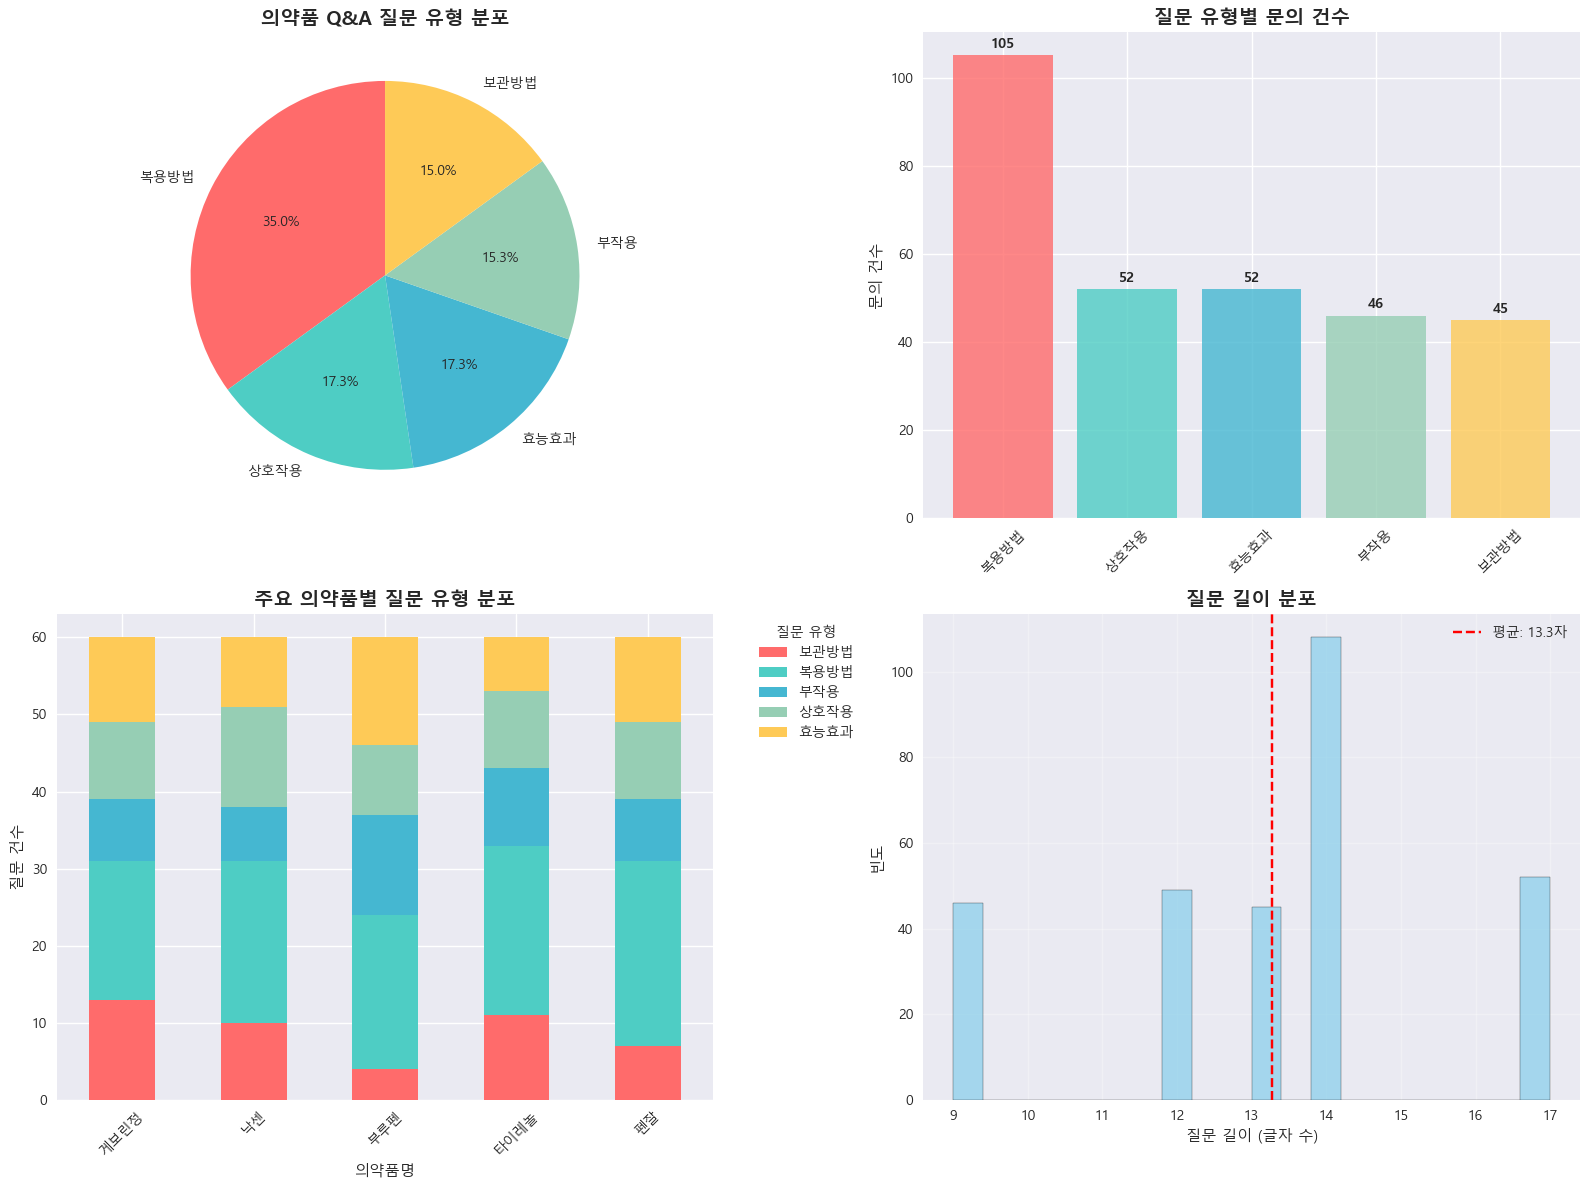


2️⃣ 응답 품질 분석


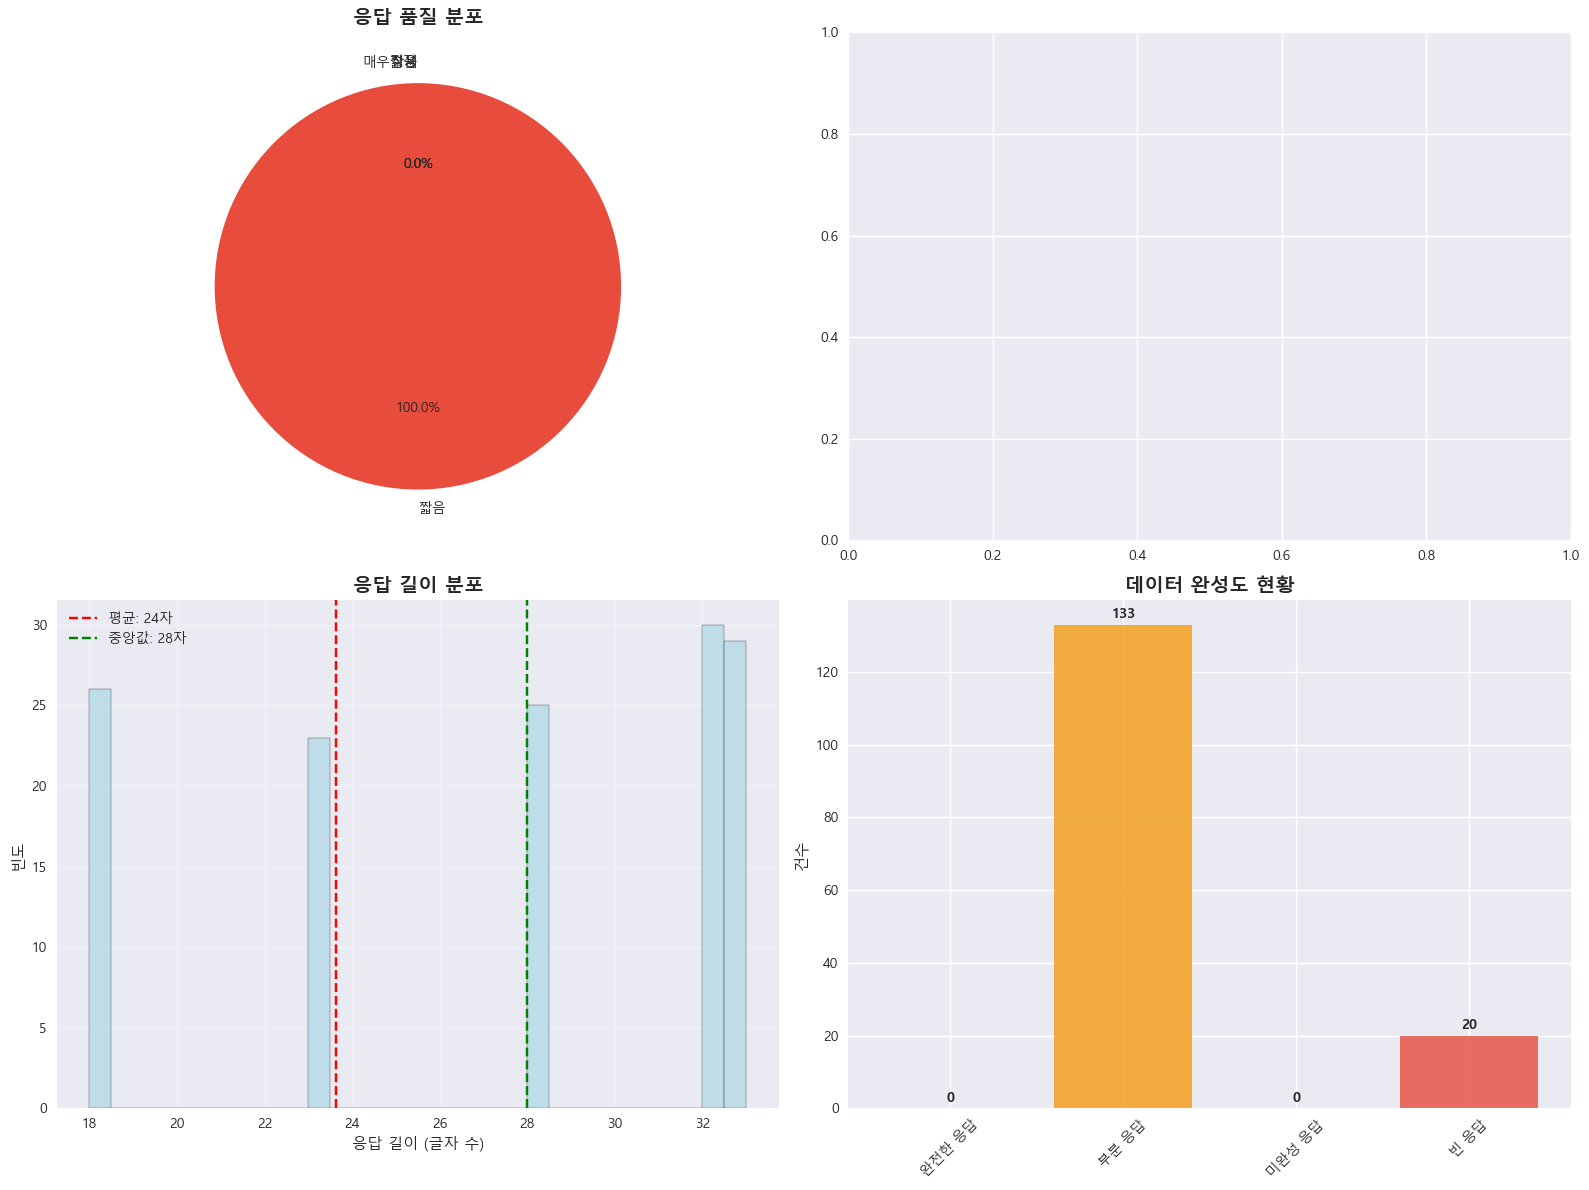


3️⃣ 의약품 카테고리 분석


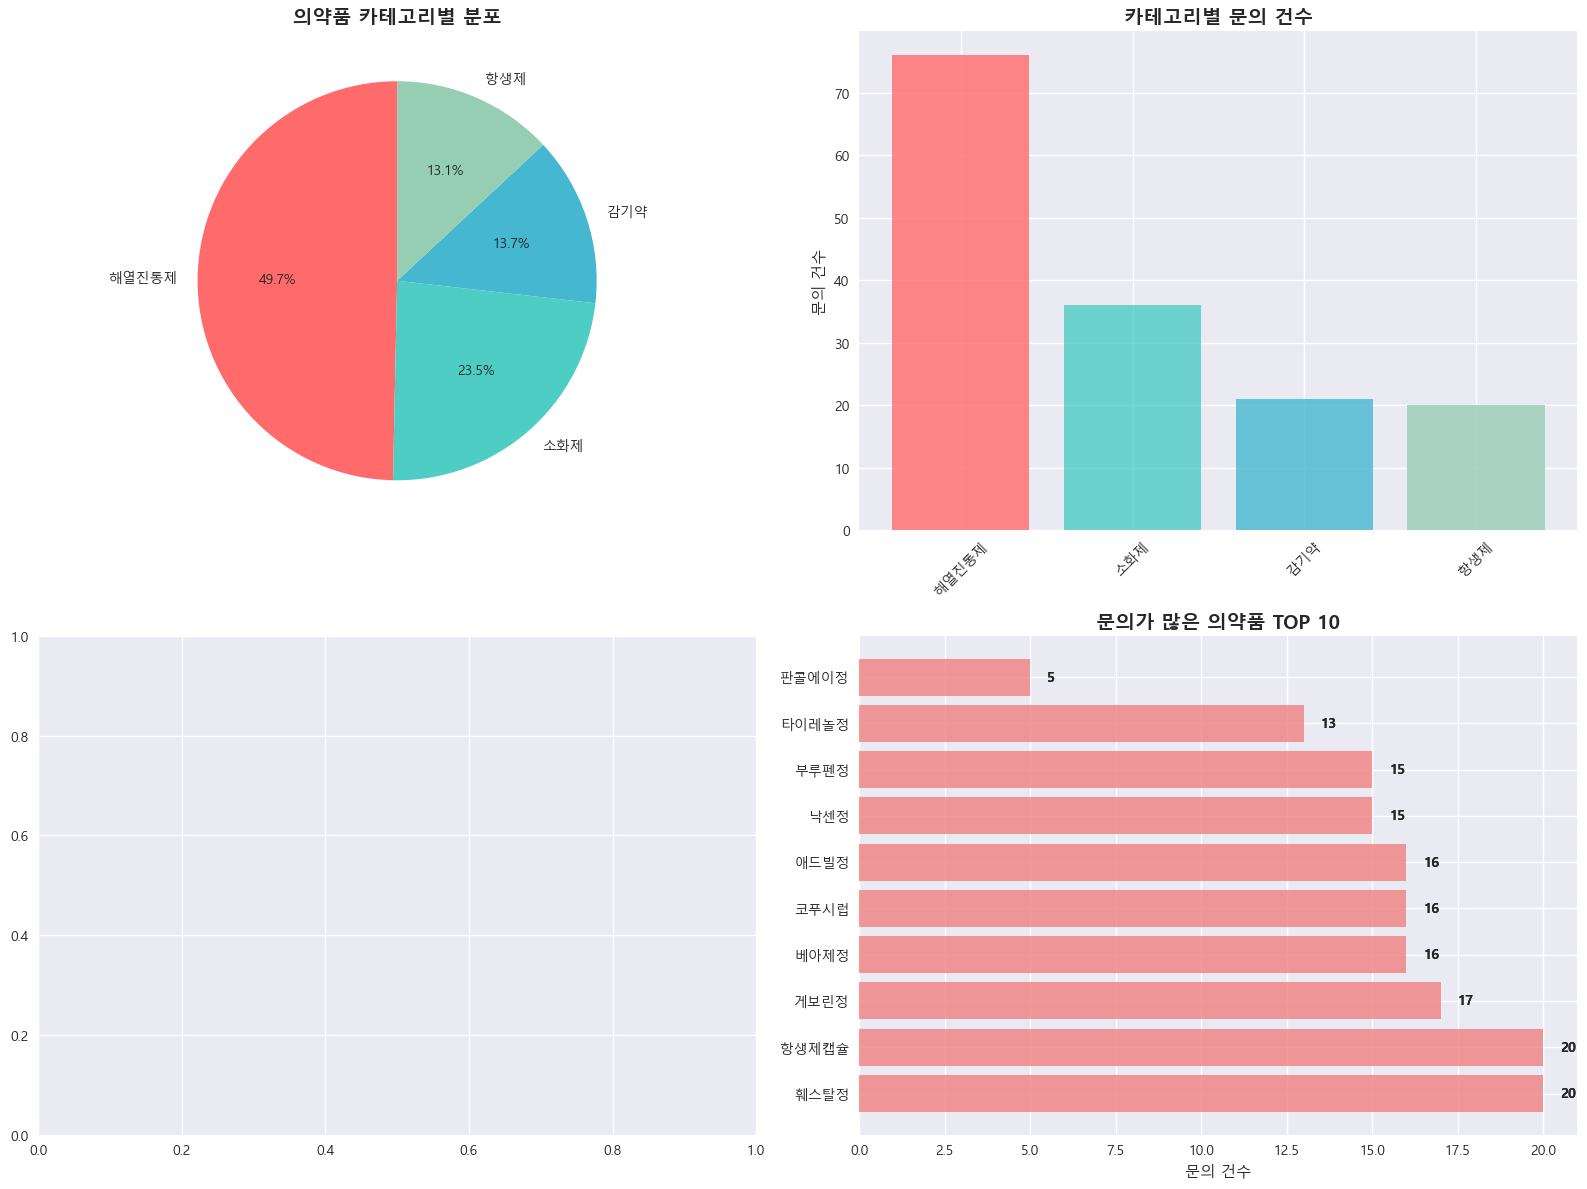


4️⃣ 키워드 빈도 분석


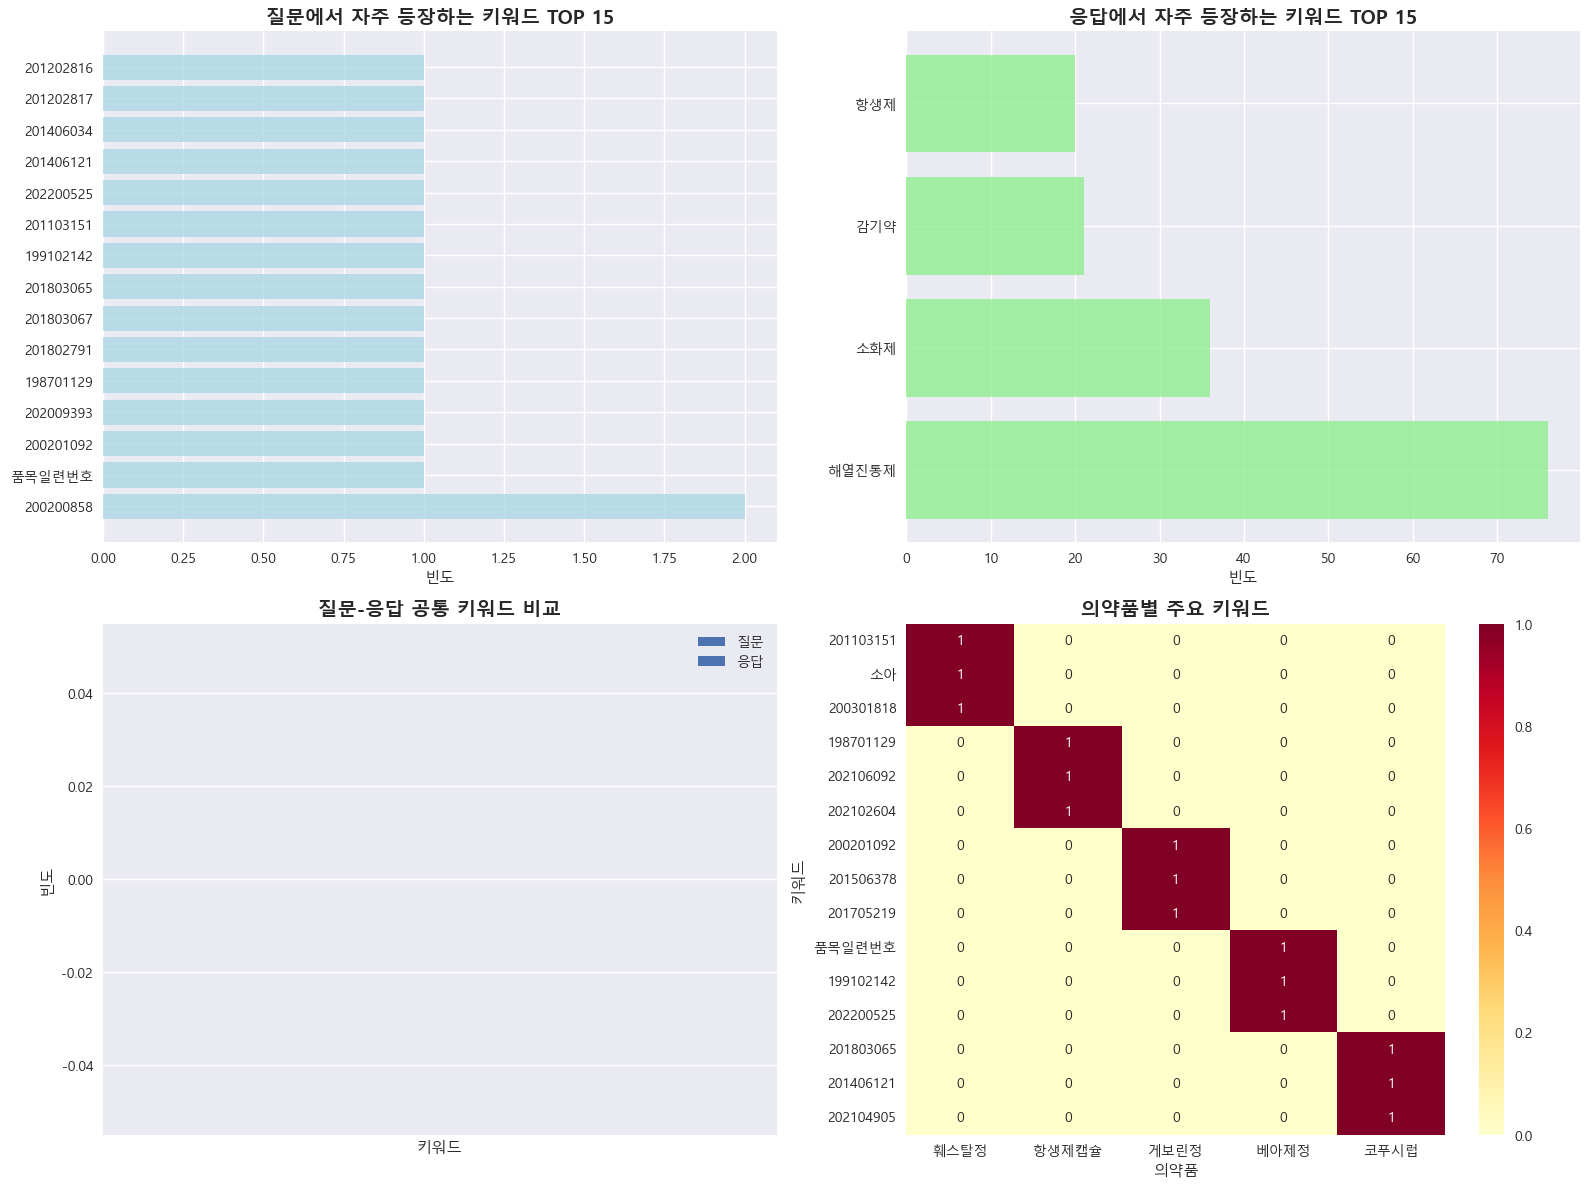


🎯 의약품 Q&A EDA 핵심 인사이트
📊 가장 많은 질문 유형: 복용방법 (105건)
📝 응답 품질 현황: 짧음 응답이 133건으로 최다
💊 주요 의약품 카테고리: 해열진통제 (76건)

💡 데이터 활용 포인트:
- 질문 유형별 표준 응답 템플릿 구축
- 응답 품질 낮은 항목 우선 개선
- 인기 의약품 위주 데이터 확장
- 키워드 기반 검색 시스템 구축


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
data_path = rdf = pd.read_excel(data_path)

# =============================================================================
# 1. 질문 유형 분석 - "어떤 질문이 가장 많이 묻는가?"
# =============================================================================
def question_type_analysis(data):
    """메시지: 6가지 표준 질문 중 어떤 유형이 가장 관심이 높은가"""
    
    # 6가지 표준 질문 정의 (PDF 기반)
    question_types = {
        '효능효과': ['효능', '효과', '무엇인지', '치료'],
        '복용방법': ['복용', '사용', '먹는', '방법', '용법'],
        '부작용': ['부작용', '이상반응', '주의사항', '금기'],
        '상호작용': ['상호작용', '함께', '같이', '병용'],
        '보관방법': ['보관', '저장', '관리'],
        '기타': ['임신', '수유', '운전', '알코올']
    }
    
    # 질문 컬럼이 있다면 분류 (컬럼명 추정)
    question_col = None
    for col in data.columns:
        if any(keyword in col.lower() for keyword in ['질문', 'question', '문의']):
            question_col = col
            break
    
    if question_col is None:
        # 샘플 데이터 생성 (실제 데이터 구조 파악용)
        sample_questions = [
            "이 약의 효능은 무엇인지?", "복용 방법을 알려주세요", "부작용이 있나요?",
            "다른 약과 함께 먹어도 되나요?", "어떻게 보관해야 하나요?", "임신 중 복용 가능한가요?"
        ] * 50
        
        df_sample = pd.DataFrame({
            'question': np.random.choice(sample_questions, 300),
            'medicine': ['게보린정', '타이레놀', '낙센', '부루펜', '펜잘'] * 60
        })
        question_col = 'question'
        data = df_sample
    
    # 질문 유형 분류
    def classify_question(question):
        question = str(question).lower()
        for qtype, keywords in question_types.items():
            if any(keyword in question for keyword in keywords):
                return qtype
        return '기타'
    
    data['question_type'] = data[question_col].apply(classify_question)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) 질문 유형별 분포
    type_counts = data['question_type'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    wedges, texts, autotexts = ax1.pie(type_counts.values, labels=type_counts.index, 
                                      autopct='%1.1f%%', colors=colors[:len(type_counts)], 
                                      startangle=90)
    ax1.set_title('의약품 Q&A 질문 유형 분포', fontsize=14, fontweight='bold')
    
    # 2) 질문 유형별 막대 차트 (개수 포함)
    ax2.bar(type_counts.index, type_counts.values, color=colors[:len(type_counts)], alpha=0.8)
    ax2.set_title('질문 유형별 문의 건수', fontsize=14, fontweight='bold')
    ax2.set_ylabel('문의 건수')
    ax2.tick_params(axis='x', rotation=45)
    
    # 막대 위에 수치 표시
    for i, v in enumerate(type_counts.values):
        ax2.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')
    
    # 3) 의약품별 질문 유형 분포 (상위 5개 의약품)
    if 'medicine' in data.columns:
        medicine_col = 'medicine'
    else:
        # 약품명 컬럼 찾기
        medicine_col = None
        for col in data.columns:
            if any(keyword in col.lower() for keyword in ['약품', '의약품', '제품', 'medicine']):
                medicine_col = col
                break
    
    if medicine_col:
        top_medicines = data[medicine_col].value_counts().head(5).index
        medicine_question = pd.crosstab(data[data[medicine_col].isin(top_medicines)][medicine_col], 
                                       data[data[medicine_col].isin(top_medicines)]['question_type'])
        
        medicine_question.plot(kind='bar', stacked=True, ax=ax3, 
                              color=colors[:len(medicine_question.columns)])
        ax3.set_title('주요 의약품별 질문 유형 분포', fontsize=14, fontweight='bold')
        ax3.set_xlabel('의약품명')
        ax3.set_ylabel('질문 건수')
        ax3.legend(title='질문 유형', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4) 질문 길이 분포 분석
    data['question_length'] = data[question_col].astype(str).apply(len)
    
    ax4.hist(data['question_length'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.axvline(data['question_length'].mean(), color='red', linestyle='--', 
               label=f'평균: {data["question_length"].mean():.1f}자')
    ax4.set_title('질문 길이 분포', fontsize=14, fontweight='bold')
    ax4.set_xlabel('질문 길이 (글자 수)')
    ax4.set_ylabel('빈도')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return type_counts

# =============================================================================
# 2. 응답 품질 분석 - "응답의 완성도는 어떤가?"
# =============================================================================
def response_quality_analysis(data):
    """메시지: 응답 데이터의 품질과 완성도 평가"""
    
    # 응답 컬럼 찾기
    response_col = None
    for col in data.columns:
        if any(keyword in col.lower() for keyword in ['응답', 'answer', '답변', '내용']):
            response_col = col
            break
    
    if response_col is None:
        # 샘플 응답 데이터 생성
        sample_responses = [
            "이 약은 두통, 치통, 발치 등의 통증 완화에 사용됩니다.",
            "성인은 1회 1정, 1일 3회까지 복용 가능합니다.",
            "복용 시 위장장애, 졸음 등의 부작용이 나타날 수 있습니다.",
            "다른 해열진통제와 함께 복용하지 마십시오.",
            "실온에서 습기를 피해 보관하세요.",
            ""  # 빈 응답도 포함
        ]
        data['response'] = np.random.choice(sample_responses, len(data))
        response_col = 'response'
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) 응답 완성도 분석
    data['response_length'] = data[response_col].astype(str).apply(len)
    data['is_empty'] = data[response_col].astype(str).apply(lambda x: x.strip() == '' or x == 'nan')
    data['response_quality'] = pd.cut(data['response_length'], 
                                   bins=[0, 10, 50, 150, float('inf')], 
                                   labels=['매우짧음', '짧음', '적정', '상세'])
    
    quality_counts = data['response_quality'].value_counts()
    quality_colors = ['#E74C3C', '#F39C12', '#27AE60', '#2ECC71']
    
    ax1.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
           colors=quality_colors, startangle=90)
    ax1.set_title('응답 품질 분포', fontsize=14, fontweight='bold')
    
    # 2) 질문 유형별 응답 품질
    if 'question_type' in data.columns:
        quality_by_type = pd.crosstab(data['question_type'], data['response_quality'])
        quality_by_type_pct = quality_by_type.div(quality_by_type.sum(axis=1), axis=0) * 100
        
        quality_by_type_pct.plot(kind='bar', stacked=True, ax=ax2, 
                                color=quality_colors)
        ax2.set_title('질문 유형별 응답 품질 분포', fontsize=14, fontweight='bold')
        ax2.set_xlabel('질문 유형')
        ax2.set_ylabel('비율 (%)')
        ax2.legend(title='응답 품질')
        ax2.tick_params(axis='x', rotation=45)
    
    # 3) 응답 길이 분포
    ax3.hist(data[data['response_length'] > 0]['response_length'], bins=30, 
            color='lightblue', alpha=0.7, edgecolor='black')
    ax3.axvline(data['response_length'].mean(), color='red', linestyle='--', 
               label=f'평균: {data["response_length"].mean():.0f}자')
    ax3.axvline(data['response_length'].median(), color='green', linestyle='--', 
               label=f'중앙값: {data["response_length"].median():.0f}자')
    ax3.set_title('응답 길이 분포', fontsize=14, fontweight='bold')
    ax3.set_xlabel('응답 길이 (글자 수)')
    ax3.set_ylabel('빈도')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4) 데이터 완성도 현황
    completeness_data = {
        '완전한 응답': len(data[data['response_length'] > 50]),
        '부분 응답': len(data[(data['response_length'] > 10) & (data['response_length'] <= 50)]),
        '미완성 응답': len(data[(data['response_length'] > 0) & (data['response_length'] <= 10)]),
        '빈 응답': len(data[data['is_empty']])
    }
    
    status_colors = ['#27AE60', '#F39C12', '#E67E22', '#E74C3C']
    ax4.bar(completeness_data.keys(), completeness_data.values(), 
           color=status_colors, alpha=0.8)
    ax4.set_title('데이터 완성도 현황', fontsize=14, fontweight='bold')
    ax4.set_ylabel('건수')
    ax4.tick_params(axis='x', rotation=45)
    
    # 막대 위에 수치 표시
    for i, (key, value) in enumerate(completeness_data.items()):
        ax4.text(i, value + 1, str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return data['response_quality'].value_counts()

# =============================================================================
# 3. 의약품 카테고리 분석 - "어떤 종류의 약품이 많은가?"
# =============================================================================
def medicine_category_analysis(data):
    """메시지: 의약품 종류별 분포와 특성 분석"""
    
    # 의약품명에서 카테고리 추출
    def categorize_medicine(medicine_name):
        medicine_name = str(medicine_name).lower()
        
        categories = {
            '해열진통제': ['타이레놀', '게보린', '낙센', '애드빌', '부루펜', '진통'],
            '감기약': ['판콜', '코푸', '코감기', '감기', '콧물'],
            '소화제': ['베아제', '훼스탈', '소화', '위장'],
            '항생제': ['항생제', '클라리', '세프', '페니실린'],
            '혈압약': ['혈압', '암로디핀', '텔미', '압탄'],
            '기타': []
        }
        
        for category, keywords in categories.items():
            if any(keyword in medicine_name for keyword in keywords):
                return category
        return '기타'
    
    # 의약품 컬럼 확인
    medicine_col = None
    for col in data.columns:
        if any(keyword in col.lower() for keyword in ['약품', '의약품', '제품', 'medicine']):
            medicine_col = col
            break
    
    if medicine_col is None:
        # 샘플 의약품 데이터 생성
        sample_medicines = [
            '타이레놀정', '게보린정', '낙센정', '애드빌정', '부루펜정',
            '판콜에이정', '코푸시럽', '베아제정', '훼스탈정', '항생제캡슐'
        ]
        data['medicine_name'] = np.random.choice(sample_medicines, len(data))
        medicine_col = 'medicine_name'
    
    data['medicine_category'] = data[medicine_col].apply(categorize_medicine)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) 의약품 카테고리별 분포
    category_counts = data['medicine_category'].value_counts()
    category_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    ax1.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
           colors=category_colors[:len(category_counts)], startangle=90)
    ax1.set_title('의약품 카테고리별 분포', fontsize=14, fontweight='bold')
    
    # 2) 카테고리별 질문 건수
    ax2.bar(category_counts.index, category_counts.values, 
           color=category_colors[:len(category_counts)], alpha=0.8)
    ax2.set_title('카테고리별 문의 건수', fontsize=14, fontweight='bold')
    ax2.set_ylabel('문의 건수')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3) 카테고리별 주요 질문 유형
    if 'question_type' in data.columns:
        category_question = pd.crosstab(data['medicine_category'], data['question_type'])
        category_question_pct = category_question.div(category_question.sum(axis=1), axis=0) * 100
        
        category_question_pct.plot(kind='bar', ax=ax3, colormap='Set3')
        ax3.set_title('카테고리별 주요 질문 유형', fontsize=14, fontweight='bold')
        ax3.set_xlabel('의약품 카테고리')
        ax3.set_ylabel('비율 (%)')
        ax3.legend(title='질문 유형', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4) 인기 의약품 TOP 10
    top_medicines = data[medicine_col].value_counts().head(10)
    
    ax4.barh(range(len(top_medicines)), top_medicines.values, color='lightcoral', alpha=0.8)
    ax4.set_yticks(range(len(top_medicines)))
    ax4.set_yticklabels(top_medicines.index)
    ax4.set_xlabel('문의 건수')
    ax4.set_title('문의가 많은 의약품 TOP 10', fontsize=14, fontweight='bold')
    
    # 막대 끝에 수치 표시
    for i, v in enumerate(top_medicines.values):
        ax4.text(v + 0.5, i, str(v), va='center', fontweight='bold')
    ax4.set_yticklabels(top_medicines.index)
    ax4.set_xlabel('문의 건수')
    ax4.set_title('문의가 많은 의약품 TOP 10', fontsize=14, fontweight='bold')
    
    # 막대 끝에 수치 표시
    for i, v in enumerate(top_medicines.values):
        ax4.text(v + 0.5, i, str(v), va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return category_counts

# =============================================================================
# 4. 키워드 빈도 분석 - "가장 관심있는 키워드는?"
# =============================================================================
def keyword_frequency_analysis(data):
    """메시지: 질문과 응답에서 가장 자주 등장하는 키워드 분석"""
    
    # 텍스트 전처리 함수
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        # 한글, 영문, 숫자만 추출
        text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', str(text))
        # 여러 공백을 하나로
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    # 불용어 리스트
    stopwords = ['이', '그', '저', '것', '수', '등', '및', '의', '가', '을', '를', '에', '는', '은', '와', '과', 
                '로', '으로', '하는', '있는', '되는', '한', '될', '됩니다', '입니다', '있습니다', '합니다']
    
    # 질문에서 키워드 추출
    question_col = [col for col in data.columns if any(keyword in col.lower() for keyword in ['질문', 'question'])][0] if any('질문' in col.lower() or 'question' in col.lower() for col in data.columns) else data.columns[0]
    
    all_questions = data[question_col].apply(preprocess_text).str.cat(sep=' ')
    question_words = [word for word in all_questions.split() if len(word) > 1 and word not in stopwords]
    question_counter = Counter(question_words)
    
    # 응답에서 키워드 추출
    response_col = [col for col in data.columns if any(keyword in col.lower() for keyword in ['응답', 'answer', '답변'])][0] if any('응답' in col.lower() or 'answer' in col.lower() for col in data.columns) else data.columns[-1]
    
    all_responses = data[response_col].apply(preprocess_text).str.cat(sep=' ')
    response_words = [word for word in all_responses.split() if len(word) > 1 and word not in stopwords]
    response_counter = Counter(response_words)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) 질문 키워드 TOP 15
    top_question_words = dict(question_counter.most_common(15))
    ax1.barh(list(top_question_words.keys()), list(top_question_words.values()), 
            color='lightblue', alpha=0.8)
    ax1.set_title('질문에서 자주 등장하는 키워드 TOP 15', fontsize=14, fontweight='bold')
    ax1.set_xlabel('빈도')
    
    # 2) 응답 키워드 TOP 15
    top_response_words = dict(response_counter.most_common(15))
    ax2.barh(list(top_response_words.keys()), list(top_response_words.values()), 
            color='lightgreen', alpha=0.8)
    ax2.set_title('응답에서 자주 등장하는 키워드 TOP 15', fontsize=14, fontweight='bold')
    ax2.set_xlabel('빈도')
    
    # 3) 질문-응답 키워드 비교 (공통 키워드)
    common_words = set(question_counter.keys()) & set(response_counter.keys())
    common_top_words = sorted(common_words, key=lambda x: question_counter[x] + response_counter[x], reverse=True)[:10]
    
    question_counts = [question_counter[word] for word in common_top_words]
    response_counts = [response_counter[word] for word in common_top_words]
    
    x = np.arange(len(common_top_words))
    width = 0.35
    
    ax3.bar(x - width/2, question_counts, width, label='질문', color='skyblue', alpha=0.8)
    ax3.bar(x + width/2, response_counts, width, label='응답', color='lightcoral', alpha=0.8)
    ax3.set_xlabel('키워드')
    ax3.set_ylabel('빈도')
    ax3.set_title('질문-응답 공통 키워드 비교', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(common_top_words, rotation=45)
    ax3.legend()
    
    # 4) 의약품별 주요 키워드 (상위 5개 의약품)
    medicine_col = [col for col in data.columns if any(keyword in col.lower() for keyword in ['약품', 'medicine'])][0] if any('약품' in col.lower() or 'medicine' in col.lower() for col in data.columns) else 'medicine_name'
    
    if medicine_col in data.columns:
        top_medicines = data[medicine_col].value_counts().head(5).index
        medicine_keywords = {}
        
        for medicine in top_medicines:
            medicine_questions = data[data[medicine_col] == medicine][question_col].apply(preprocess_text).str.cat(sep=' ')
            medicine_words = [word for word in medicine_questions.split() if len(word) > 1 and word not in stopwords]
            medicine_keywords[medicine] = dict(Counter(medicine_words).most_common(3))
        
        # 히트맵 형태로 표시
        medicine_keyword_df = pd.DataFrame(medicine_keywords).fillna(0)
        
        sns.heatmap(medicine_keyword_df, annot=True, cmap='YlOrRd', ax=ax4, fmt='g')
        ax4.set_title('의약품별 주요 키워드', fontsize=14, fontweight='bold')
        ax4.set_xlabel('의약품')
        ax4.set_ylabel('키워드')
    
    plt.tight_layout()
    plt.show()
    
    return question_counter.most_common(10), response_counter.most_common(10)

# =============================================================================
# 실행 및 결과 요약
# =============================================================================

print("💊 의약품 Q&A 데이터 EDA 분석 시작")
print("="*60)

print("\n1️⃣ 질문 유형 분석")
question_analysis = question_type_analysis(df)

print("\n2️⃣ 응답 품질 분석")
quality_analysis = response_quality_analysis(df)

print("\n3️⃣ 의약품 카테고리 분석")
category_analysis = medicine_category_analysis(df)

print("\n4️⃣ 키워드 빈도 분석")
keyword_analysis = keyword_frequency_analysis(df)

# 핵심 인사이트 요약
print("\n" + "="*60)
print("🎯 의약품 Q&A EDA 핵심 인사이트")
print("="*60)

print(f"📊 가장 많은 질문 유형: {question_analysis.index[0]} ({question_analysis.iloc[0]}건)")
print(f"📝 응답 품질 현황: {quality_analysis.index[0]} 응답이 {quality_analysis.iloc[0]}건으로 최다")
print(f"💊 주요 의약품 카테고리: {category_analysis.index[0]} ({category_analysis.iloc[0]}건)")

print("\n💡 데이터 활용 포인트:")
print("- 질문 유형별 표준 응답 템플릿 구축")
print("- 응답 품질 낮은 항목 우선 개선")
print("- 인기 의약품 위주 데이터 확장")
print("- 키워드 기반 검색 시스템 구축")
print("="*60)

🤖 AI 모델 답변 비교 EDA 분석 시작

1️⃣ 기본 데이터 구조 비교


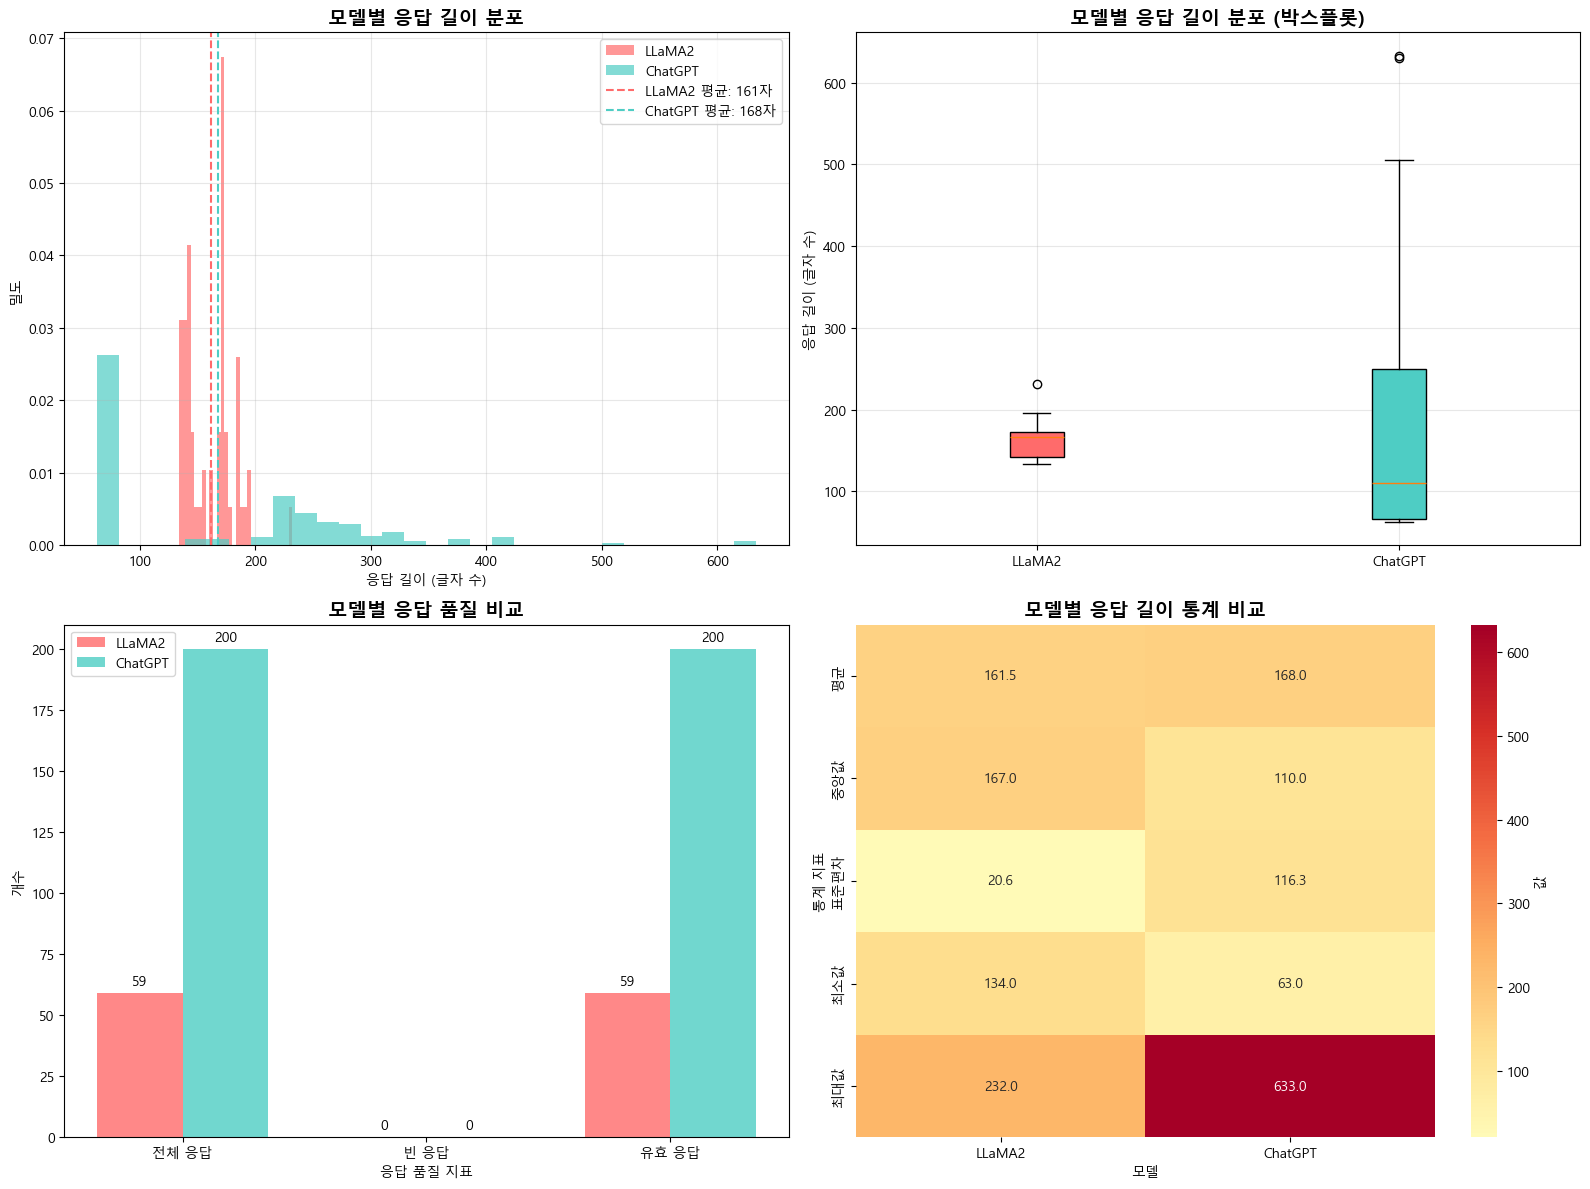


2️⃣ 응답 구조 및 품질 분석


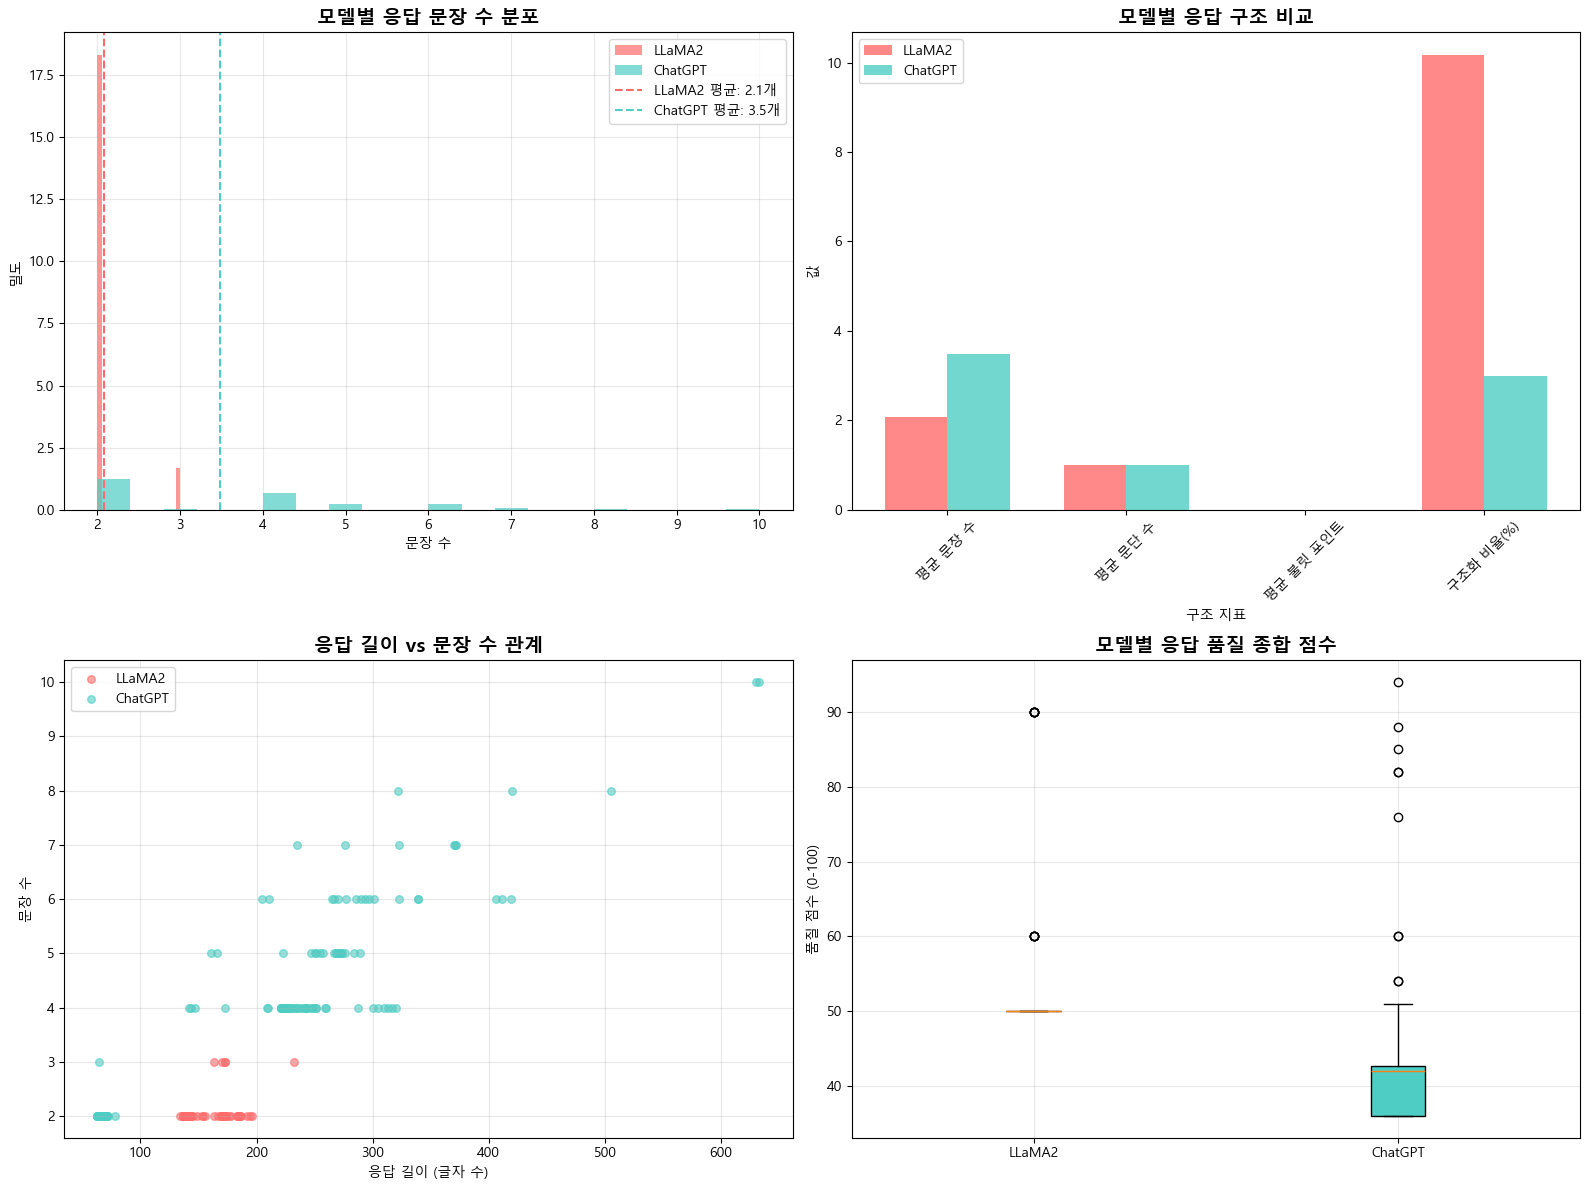


3️⃣ 내용 및 키워드 분석


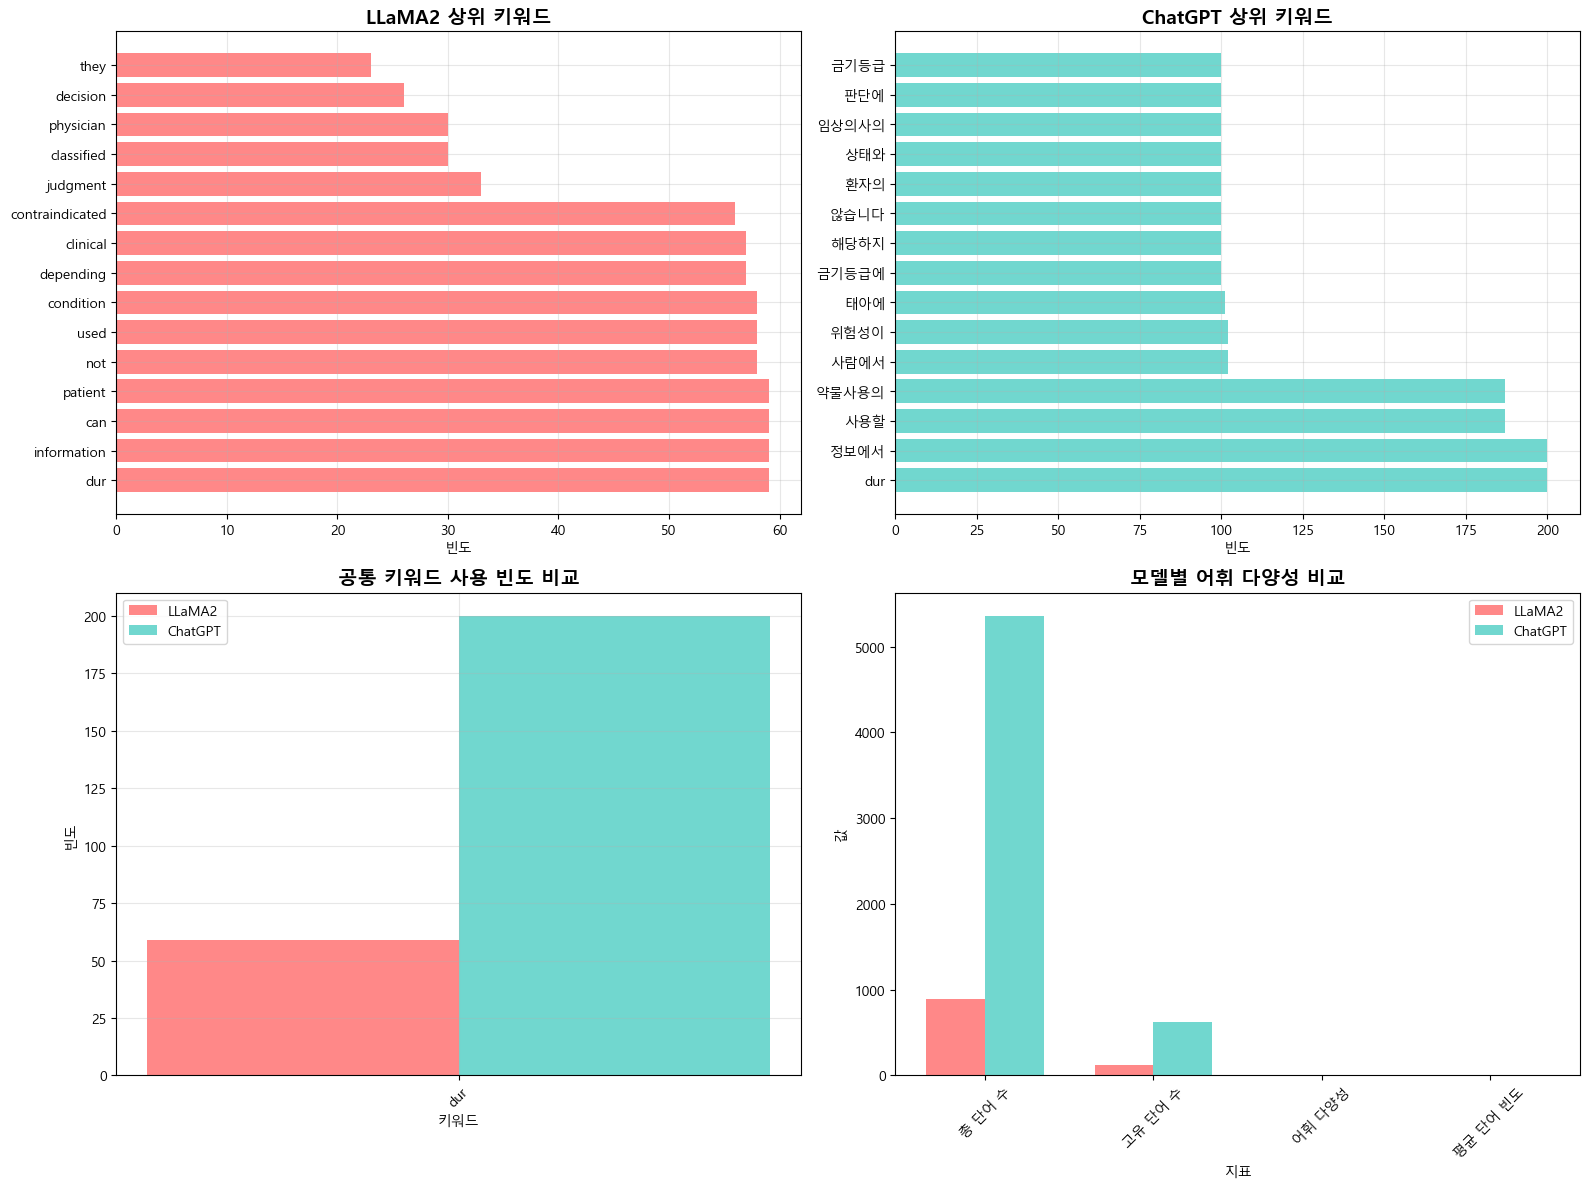


4️⃣ 종합 성능 비교


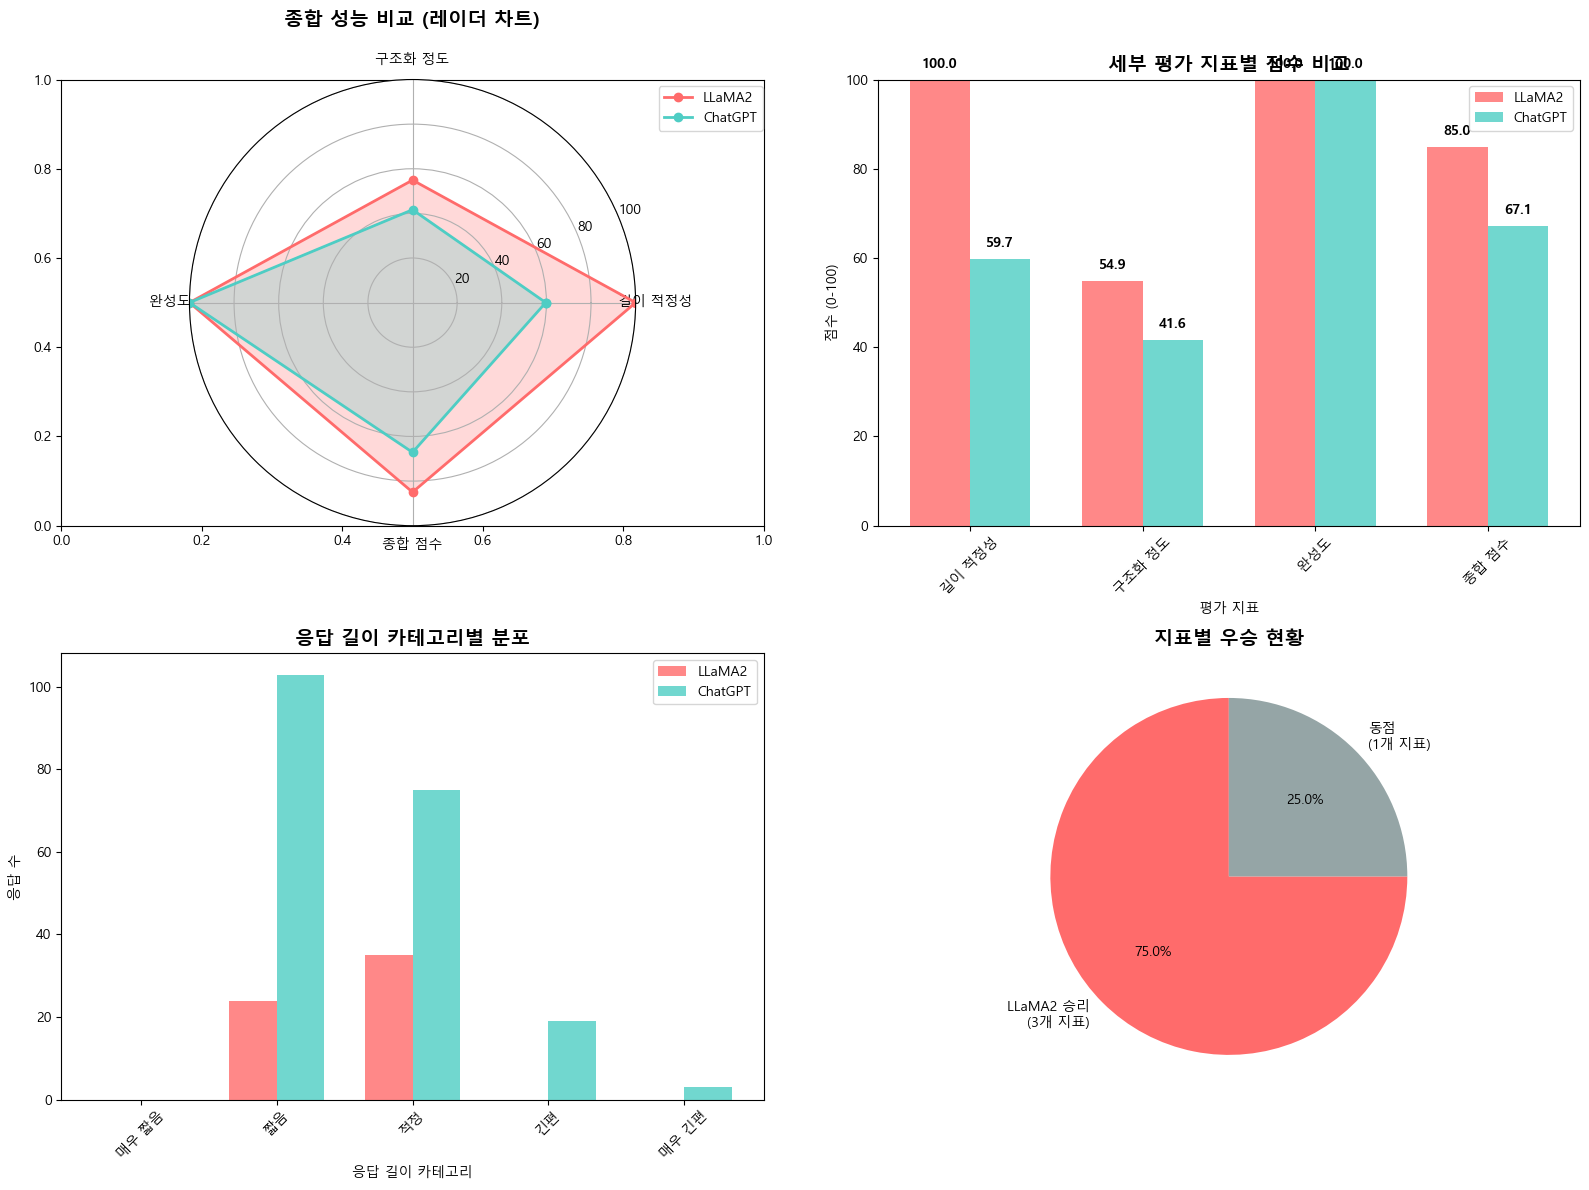


🏆 AI 모델 비교 핵심 결과
📊 평균 응답 길이: LLaMA2 161자 vs ChatGPT 168자
🏗️  구조화 점수: LLaMA2 54.9 vs ChatGPT 41.6
✅ 완성도 점수: LLaMA2 100.0% vs ChatGPT 100.0%
🎯 종합 점수: LLaMA2 85.0 vs ChatGPT 67.1

🏆 최종 우승자: LLaMA2
📈 지표별 우승: {'length_score': 'LLaMA2', 'structure_score': 'LLaMA2', 'completeness_score': '동점', 'overall_score': 'LLaMA2'}

🔤 공통 키워드 TOP 5: ['dur']

💡 주요 발견사항:
- ChatGPT가 더 긴 응답을 제공
- LLaMA2가 더 구조화된 응답
- 두 모델 모두 고유한 강점 보유
- 사용 목적에 따른 모델 선택 필요


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textstat import flesch_reading_ease, flesch_kincaid_grade
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
llama_path = r"C:\Users\82102\OneDrive\바탕 화면\clova_response\llama2_13b_chat_gptq_response_en\name_to_pregnancy_en.xlsx"
chatgpt_path = r"C:\Users\82102\OneDrive\바탕 화면\chatgpt\name_to_pregnancy 한글.xlsx"

df_llama = pd.read_excel(llama_path)
df_chatgpt = pd.read_excel(chatgpt_path)

# 데이터에 모델명 추가
df_llama['model'] = 'LLaMA2'
df_chatgpt['model'] = 'ChatGPT'

# =============================================================================
# 1. 기본 데이터 구조 비교 - "두 모델의 응답 패턴이 어떻게 다른가?"
# =============================================================================
def basic_comparison_analysis(llama_data, chatgpt_data):
    """메시지: 두 AI 모델의 기본 응답 특성 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 응답 컬럼 자동 탐지
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]  # 마지막 컬럼을 응답으로 가정
    
    llama_resp_col = find_response_column(llama_data)
    chatgpt_resp_col = find_response_column(chatgpt_data)
    
    # 응답 길이 계산
    llama_data['response_length'] = llama_data[llama_resp_col].astype(str).apply(len)
    chatgpt_data['response_length'] = chatgpt_data[chatgpt_resp_col].astype(str).apply(len)
    
    # 1) 응답 길이 분포 비교
    ax1.hist(llama_data['response_length'], bins=30, alpha=0.7, label='LLaMA2', 
            color='#FF6B6B', density=True)
    ax1.hist(chatgpt_data['response_length'], bins=30, alpha=0.7, label='ChatGPT', 
            color='#4ECDC4', density=True)
    ax1.axvline(llama_data['response_length'].mean(), color='#FF6B6B', linestyle='--', 
               label=f'LLaMA2 평균: {llama_data["response_length"].mean():.0f}자')
    ax1.axvline(chatgpt_data['response_length'].mean(), color='#4ECDC4', linestyle='--', 
               label=f'ChatGPT 평균: {chatgpt_data["response_length"].mean():.0f}자')
    ax1.set_xlabel('응답 길이 (글자 수)')
    ax1.set_ylabel('밀도')
    ax1.set_title('모델별 응답 길이 분포', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2) 응답 길이 박스플롯
    length_data = [llama_data['response_length'], chatgpt_data['response_length']]
    bp = ax2.boxplot(length_data, labels=['LLaMA2', 'ChatGPT'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#4ECDC4')
    ax2.set_ylabel('응답 길이 (글자 수)')
    ax2.set_title('모델별 응답 길이 분포 (박스플롯)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3) 데이터 품질 비교
    llama_empty = len(llama_data[llama_data[llama_resp_col].astype(str).str.strip() == ''])
    chatgpt_empty = len(chatgpt_data[chatgpt_data[chatgpt_resp_col].astype(str).str.strip() == ''])
    
    quality_metrics = {
        '전체 응답': [len(llama_data), len(chatgpt_data)],
        '빈 응답': [llama_empty, chatgpt_empty],
        '유효 응답': [len(llama_data) - llama_empty, len(chatgpt_data) - chatgpt_empty]
    }
    
    x = np.arange(len(quality_metrics))
    width = 0.35
    
    llama_values = [quality_metrics[key][0] for key in quality_metrics.keys()]
    chatgpt_values = [quality_metrics[key][1] for key in quality_metrics.keys()]
    
    ax3.bar(x - width/2, llama_values, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax3.bar(x + width/2, chatgpt_values, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax3.set_xlabel('응답 품질 지표')
    ax3.set_ylabel('개수')
    ax3.set_title('모델별 응답 품질 비교', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(quality_metrics.keys())
    ax3.legend()
    
    # 값 표시
    for i, (l_val, c_val) in enumerate(zip(llama_values, chatgpt_values)):
        ax3.text(i - width/2, l_val + max(llama_values + chatgpt_values) * 0.01, 
                str(l_val), ha='center', va='bottom')
        ax3.text(i + width/2, c_val + max(llama_values + chatgpt_values) * 0.01, 
                str(c_val), ha='center', va='bottom')
    
    # 4) 기본 통계 비교
    stats_comparison = pd.DataFrame({
        'LLaMA2': [
            llama_data['response_length'].mean(),
            llama_data['response_length'].median(),
            llama_data['response_length'].std(),
            llama_data['response_length'].min(),
            llama_data['response_length'].max()
        ],
        'ChatGPT': [
            chatgpt_data['response_length'].mean(),
            chatgpt_data['response_length'].median(),
            chatgpt_data['response_length'].std(),
            chatgpt_data['response_length'].min(),
            chatgpt_data['response_length'].max()
        ]
    }, index=['평균', '중앙값', '표준편차', '최소값', '최대값'])
    
    # 히트맵으로 표시
    sns.heatmap(stats_comparison, annot=True, cmap='RdYlBu_r', center=0, 
               fmt='.1f', ax=ax4, cbar_kws={'label': '값'})
    ax4.set_title('모델별 응답 길이 통계 비교', fontsize=14, fontweight='bold')
    ax4.set_xlabel('모델')
    ax4.set_ylabel('통계 지표')
    
    plt.tight_layout()
    plt.show()
    
    return stats_comparison

# =============================================================================
# 2. 응답 품질 및 구조 분석 - "어떤 모델이 더 구조적인 답변을 하는가?"
# =============================================================================
def response_structure_analysis(llama_data, chatgpt_data):
    """메시지: 응답의 구조적 특성과 품질 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_resp_col = find_response_column(llama_data)
    chatgpt_resp_col = find_response_column(chatgpt_data)
    
    # 응답 구조 분석 함수들
    def count_sentences(text):
        if pd.isna(text):
            return 0
        # 문장 끝 기호로 문장 수 계산
        sentences = re.split(r'[.!?。！？]', str(text))
        return len([s for s in sentences if s.strip()])
    
    def count_bullet_points(text):
        if pd.isna(text):
            return 0
        # 불릿 포인트 패턴 찾기
        bullet_patterns = r'[-*•\d+\.\)\s]'
        lines = str(text).split('\n')
        return len([line for line in lines if re.match(bullet_patterns, line.strip())])
    
    def count_paragraphs(text):
        if pd.isna(text):
            return 0
        # 문단 수 계산 (더블 개행 기준)
        paragraphs = str(text).split('\n\n')
        return len([p for p in paragraphs if p.strip()])
    
    def has_structured_format(text):
        if pd.isna(text):
            return False
        text = str(text)
        # 구조화된 형식 패턴 확인
        structured_patterns = [
            r'\d+\.',  # 번호 매기기
            r'[-*•]',  # 불릿 포인트
            r':\s*\n',  # 콜론 후 개행
            r'\n\s*\n'  # 빈 줄로 구분
        ]
        return any(re.search(pattern, text) for pattern in structured_patterns)
    
    # 구조 지표 계산
    llama_data['sentence_count'] = llama_data[llama_resp_col].apply(count_sentences)
    llama_data['bullet_count'] = llama_data[llama_resp_col].apply(count_bullet_points)
    llama_data['paragraph_count'] = llama_data[llama_resp_col].apply(count_paragraphs)
    llama_data['is_structured'] = llama_data[llama_resp_col].apply(has_structured_format)
    
    chatgpt_data['sentence_count'] = chatgpt_data[chatgpt_resp_col].apply(count_sentences)
    chatgpt_data['bullet_count'] = chatgpt_data[chatgpt_resp_col].apply(count_bullet_points)
    chatgpt_data['paragraph_count'] = chatgpt_data[chatgpt_resp_col].apply(count_paragraphs)
    chatgpt_data['is_structured'] = chatgpt_data[chatgpt_resp_col].apply(has_structured_format)
    
    # 1) 문장 수 비교
    ax1.hist(llama_data['sentence_count'], bins=20, alpha=0.7, label='LLaMA2', 
            color='#FF6B6B', density=True)
    ax1.hist(chatgpt_data['sentence_count'], bins=20, alpha=0.7, label='ChatGPT', 
            color='#4ECDC4', density=True)
    ax1.axvline(llama_data['sentence_count'].mean(), color='#FF6B6B', linestyle='--',
               label=f'LLaMA2 평균: {llama_data["sentence_count"].mean():.1f}개')
    ax1.axvline(chatgpt_data['sentence_count'].mean(), color='#4ECDC4', linestyle='--',
               label=f'ChatGPT 평균: {chatgpt_data["sentence_count"].mean():.1f}개')
    ax1.set_xlabel('문장 수')
    ax1.set_ylabel('밀도')
    ax1.set_title('모델별 응답 문장 수 분포', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2) 구조화 정도 비교
    structure_comparison = {
        '평균 문장 수': [llama_data['sentence_count'].mean(), chatgpt_data['sentence_count'].mean()],
        '평균 문단 수': [llama_data['paragraph_count'].mean(), chatgpt_data['paragraph_count'].mean()],
        '평균 불릿 포인트': [llama_data['bullet_count'].mean(), chatgpt_data['bullet_count'].mean()],
        '구조화 비율(%)': [llama_data['is_structured'].mean() * 100, chatgpt_data['is_structured'].mean() * 100]
    }
    
    x = np.arange(len(structure_comparison))
    width = 0.35
    
    llama_struct = [structure_comparison[key][0] for key in structure_comparison.keys()]
    chatgpt_struct = [structure_comparison[key][1] for key in structure_comparison.keys()]
    
    ax2.bar(x - width/2, llama_struct, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax2.bar(x + width/2, chatgpt_struct, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax2.set_xlabel('구조 지표')
    ax2.set_ylabel('값')
    ax2.set_title('모델별 응답 구조 비교', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(structure_comparison.keys(), rotation=45)
    ax2.legend()
    
    # 3) 응답 길이 vs 문장 수 산점도
    ax3.scatter(llama_data['response_length'], llama_data['sentence_count'], 
               alpha=0.6, label='LLaMA2', color='#FF6B6B', s=30)
    ax3.scatter(chatgpt_data['response_length'], chatgpt_data['sentence_count'], 
               alpha=0.6, label='ChatGPT', color='#4ECDC4', s=30)
    ax3.set_xlabel('응답 길이 (글자 수)')
    ax3.set_ylabel('문장 수')
    ax3.set_title('응답 길이 vs 문장 수 관계', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4) 응답 품질 종합 점수
    # 정규화된 점수 계산
    llama_data['quality_score'] = (
        (llama_data['sentence_count'] / llama_data['sentence_count'].max() * 30) +
        (llama_data['paragraph_count'] / max(llama_data['paragraph_count'].max(), 1) * 30) +
        (llama_data['is_structured'].astype(int) * 40)
    )
    
    chatgpt_data['quality_score'] = (
        (chatgpt_data['sentence_count'] / chatgpt_data['sentence_count'].max() * 30) +
        (chatgpt_data['paragraph_count'] / max(chatgpt_data['paragraph_count'].max(), 1) * 30) +
        (chatgpt_data['is_structured'].astype(int) * 40)
    )
    
    quality_data = [llama_data['quality_score'], chatgpt_data['quality_score']]
    bp = ax4.boxplot(quality_data, labels=['LLaMA2', 'ChatGPT'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#4ECDC4')
    ax4.set_ylabel('품질 점수 (0-100)')
    ax4.set_title('모델별 응답 품질 종합 점수', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return structure_comparison

# =============================================================================
# 3. 키워드 및 내용 분석 - "어떤 모델이 더 풍부한 내용을 제공하는가?"
# =============================================================================
def content_analysis(llama_data, chatgpt_data):
    """메시지: 응답 내용의 풍부함과 키워드 다양성 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_resp_col = find_response_column(llama_data)
    chatgpt_resp_col = find_response_column(chatgpt_data)
    
    # 텍스트 전처리
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        # 영문/한글/숫자만 추출, 소문자 변환
        text = re.sub(r'[^a-zA-Z가-힣0-9\s]', ' ', str(text).lower())
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    # 불용어 (한글 + 영어)
    stopwords = ['이', '그', '저', '것', '수', '등', '및', '의', '가', '을', '를', '에', '는', '은', '와', '과',
                'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                '있습니다', '됩니다', '합니다', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had']
    
    # 키워드 추출
    def extract_keywords(texts):
        all_text = ' '.join([preprocess_text(text) for text in texts])
        words = [word for word in all_text.split() if len(word) > 2 and word not in stopwords]
        return Counter(words)
    
    llama_keywords = extract_keywords(llama_data[llama_resp_col])
    chatgpt_keywords = extract_keywords(chatgpt_data[chatgpt_resp_col])
    
    # 1) 상위 키워드 비교
    top_llama = dict(llama_keywords.most_common(15))
    top_chatgpt = dict(chatgpt_keywords.most_common(15))
    
    y_pos = np.arange(len(top_llama))
    ax1.barh(y_pos, list(top_llama.values()), alpha=0.8, color='#FF6B6B', label='LLaMA2')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(list(top_llama.keys()))
    ax1.set_xlabel('빈도')
    ax1.set_title('LLaMA2 상위 키워드', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    y_pos2 = np.arange(len(top_chatgpt))
    ax2.barh(y_pos2, list(top_chatgpt.values()), alpha=0.8, color='#4ECDC4', label='ChatGPT')
    ax2.set_yticks(y_pos2)
    ax2.set_yticklabels(list(top_chatgpt.keys()))
    ax2.set_xlabel('빈도')
    ax2.set_title('ChatGPT 상위 키워드', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3) 공통 키워드 비교
    common_keywords = set(llama_keywords.keys()) & set(chatgpt_keywords.keys())
    common_top = sorted(common_keywords, 
                       key=lambda x: llama_keywords[x] + chatgpt_keywords[x], 
                       reverse=True)[:10]
    
    llama_common_counts = [llama_keywords[word] for word in common_top]
    chatgpt_common_counts = [chatgpt_keywords[word] for word in common_top]
    
    x = np.arange(len(common_top))
    width = 0.35
    
    ax3.bar(x - width/2, llama_common_counts, width, label='LLaMA2', 
           color='#FF6B6B', alpha=0.8)
    ax3.bar(x + width/2, chatgpt_common_counts, width, label='ChatGPT', 
           color='#4ECDC4', alpha=0.8)
    ax3.set_xlabel('키워드')
    ax3.set_ylabel('빈도')
    ax3.set_title('공통 키워드 사용 빈도 비교', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(common_top, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4) 어휘 다양성 지표
    def vocabulary_diversity(keywords_counter):
        total_words = sum(keywords_counter.values())
        unique_words = len(keywords_counter)
        if total_words == 0:
            return 0
        return unique_words / total_words
    
    def average_word_frequency(keywords_counter):
        if len(keywords_counter) == 0:
            return 0
        return sum(keywords_counter.values()) / len(keywords_counter)
    
    diversity_metrics = {
        '총 단어 수': [sum(llama_keywords.values()), sum(chatgpt_keywords.values())],
        '고유 단어 수': [len(llama_keywords), len(chatgpt_keywords)],
        '어휘 다양성': [vocabulary_diversity(llama_keywords), vocabulary_diversity(chatgpt_keywords)],
        '평균 단어 빈도': [average_word_frequency(llama_keywords), average_word_frequency(chatgpt_keywords)]
    }
    
    x = np.arange(len(diversity_metrics))
    width = 0.35
    
    llama_diversity = [diversity_metrics[key][0] for key in diversity_metrics.keys()]
    chatgpt_diversity = [diversity_metrics[key][1] for key in diversity_metrics.keys()]
    
    ax4.bar(x - width/2, llama_diversity, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax4.bar(x + width/2, chatgpt_diversity, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax4.set_xlabel('지표')
    ax4.set_ylabel('값')
    ax4.set_title('모델별 어휘 다양성 비교', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(diversity_metrics.keys(), rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return diversity_metrics, common_top

# =============================================================================
# 4. 종합 성능 비교 - "전반적으로 어떤 모델이 더 우수한가?"
# =============================================================================
def comprehensive_comparison(llama_data, chatgpt_data):
    """메시지: 다양한 지표를 종합한 모델 성능 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_resp_col = find_response_column(llama_data)
    chatgpt_resp_col = find_response_column(chatgpt_data)
    
    # 종합 평가 지표 계산
    def calculate_comprehensive_score(data, resp_col):
        # 길이 점수 (적정 길이 기준 100-500자)
        optimal_length = 300
        length_scores = []
        for length in data['response_length']:
            if 100 <= length <= 500:
                length_scores.append(100)
            else:
                penalty = abs(length - optimal_length) / optimal_length * 100
                length_scores.append(max(0, 100 - penalty))
        
        # 구조 점수
        structure_scores = data['quality_score'] if 'quality_score' in data.columns else [50] * len(data)
        
        # 완성도 점수 (빈 응답이 아닌 비율)
        valid_responses = data[resp_col].astype(str).str.strip() != ''
        completeness_score = valid_responses.mean() * 100
        
        return {
            'length_score': np.mean(length_scores),
            'structure_score': np.mean(structure_scores),
            'completeness_score': completeness_score,
            'overall_score': (np.mean(length_scores) + np.mean(structure_scores) + completeness_score) / 3
        }
    
    llama_scores = calculate_comprehensive_score(llama_data, llama_resp_col)
    chatgpt_scores = calculate_comprehensive_score(chatgpt_data, chatgpt_resp_col)
    
    # 1) 레이더 차트 - 종합 성능 비교
    categories = ['길이 적정성', '구조화 정도', '완성도', '종합 점수']
    llama_values = [llama_scores['length_score'], llama_scores['structure_score'], 
                   llama_scores['completeness_score'], llama_scores['overall_score']]
    chatgpt_values = [chatgpt_scores['length_score'], chatgpt_scores['structure_score'], 
                     chatgpt_scores['completeness_score'], chatgpt_scores['overall_score']]
    
    # 레이더 차트를 위한 각도 계산
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    llama_values += llama_values[:1]  # 닫힌 도형을 위해
    chatgpt_values += chatgpt_values[:1]
    angles += angles[:1]
    
    ax1 = plt.subplot(2, 2, 1, projection='polar')
    ax1.plot(angles, llama_values, 'o-', linewidth=2, label='LLaMA2', color='#FF6B6B')
    ax1.fill(angles, llama_values, alpha=0.25, color='#FF6B6B')
    ax1.plot(angles, chatgpt_values, 'o-', linewidth=2, label='ChatGPT', color='#4ECDC4')
    ax1.fill(angles, chatgpt_values, alpha=0.25, color='#4ECDC4')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories)
    ax1.set_ylim(0, 100)
    ax1.set_title('종합 성능 비교 (레이더 차트)', fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax1.grid(True)
    
    # 2) 점수별 막대 차트
    score_comparison = {
        '길이 적정성': [llama_scores['length_score'], chatgpt_scores['length_score']],
        '구조화 정도': [llama_scores['structure_score'], chatgpt_scores['structure_score']],
        '완성도': [llama_scores['completeness_score'], chatgpt_scores['completeness_score']],
        '종합 점수': [llama_scores['overall_score'], chatgpt_scores['overall_score']]
    }
    
    x = np.arange(len(score_comparison))
    width = 0.35
    
    llama_comp_scores = [score_comparison[key][0] for key in score_comparison.keys()]
    chatgpt_comp_scores = [score_comparison[key][1] for key in score_comparison.keys()]
    
    ax2.bar(x - width/2, llama_comp_scores, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax2.bar(x + width/2, chatgpt_comp_scores, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax2.set_xlabel('평가 지표')
    ax2.set_ylabel('점수 (0-100)')
    ax2.set_title('세부 평가 지표별 점수 비교', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(score_comparison.keys(), rotation=45)
    ax2.legend()
    ax2.set_ylim(0, 100)
    
    # 점수 표시
    for i, (l_score, c_score) in enumerate(zip(llama_comp_scores, chatgpt_comp_scores)):
        ax2.text(i - width/2, l_score + 2, f'{l_score:.1f}', ha='center', va='bottom', fontweight='bold')
        ax2.text(i + width/2, c_score + 2, f'{c_score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 3) 응답 길이 카테고리별 분포
    def categorize_length(length):
        if length < 50:
            return '매우 짧음'
        elif length < 150:
            return '짧음'
        elif length < 300:
            return '적정'
        elif length < 500:
            return '긴편'
        else:
            return '매우 긴편'
    
    llama_data['length_category'] = llama_data['response_length'].apply(categorize_length)
    chatgpt_data['length_category'] = chatgpt_data['response_length'].apply(categorize_length)
    
    llama_length_dist = llama_data['length_category'].value_counts()
    chatgpt_length_dist = chatgpt_data['length_category'].value_counts()
    
    # 모든 카테고리 확보
    all_categories = ['매우 짧음', '짧음', '적정', '긴편', '매우 긴편']
    llama_dist_values = [llama_length_dist.get(cat, 0) for cat in all_categories]
    chatgpt_dist_values = [chatgpt_length_dist.get(cat, 0) for cat in all_categories]
    
    x3 = np.arange(len(all_categories))
    ax3.bar(x3 - width/2, llama_dist_values, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax3.bar(x3 + width/2, chatgpt_dist_values, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax3.set_xlabel('응답 길이 카테고리')
    ax3.set_ylabel('응답 수')
    ax3.set_title('응답 길이 카테고리별 분포', fontsize=14, fontweight='bold')
    ax3.set_xticks(x3)
    ax3.set_xticklabels(all_categories, rotation=45)
    ax3.legend()
    
    # 4) 최종 우승자 결정
    winner_analysis = {}
    metrics = ['length_score', 'structure_score', 'completeness_score', 'overall_score']
    
    for metric in metrics:
        if llama_scores[metric] > chatgpt_scores[metric]:
            winner_analysis[metric] = 'LLaMA2'
        elif chatgpt_scores[metric] > llama_scores[metric]:
            winner_analysis[metric] = 'ChatGPT'
        else:
            winner_analysis[metric] = '동점'
    
    # 승리 횟수 계산
    llama_wins = sum(1 for winner in winner_analysis.values() if winner == 'LLaMA2')
    chatgpt_wins = sum(1 for winner in winner_analysis.values() if winner == 'ChatGPT')
    ties = sum(1 for winner in winner_analysis.values() if winner == '동점')
    
    # 파이차트로 표시
    sizes = [llama_wins, chatgpt_wins, ties]
    labels = [f'LLaMA2 승리\n({llama_wins}개 지표)', f'ChatGPT 승리\n({chatgpt_wins}개 지표)', f'동점\n({ties}개 지표)']
    colors = ['#FF6B6B', '#4ECDC4', '#95A5A6']
    
    # 0인 값 제거
    non_zero_data = [(size, label, color) for size, label, color in zip(sizes, labels, colors) if size > 0]
    if non_zero_data:
        sizes, labels, colors = zip(*non_zero_data)
        
        ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax4.set_title('지표별 우승 현황', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return llama_scores, chatgpt_scores, winner_analysis

# =============================================================================
# 실행 및 결과 요약
# =============================================================================

print("🤖 AI 모델 답변 비교 EDA 분석 시작")
print("="*70)

print("\n1️⃣ 기본 데이터 구조 비교")
basic_stats = basic_comparison_analysis(df_llama, df_chatgpt)

print("\n2️⃣ 응답 구조 및 품질 분석")
structure_stats = response_structure_analysis(df_llama, df_chatgpt)

print("\n3️⃣ 내용 및 키워드 분석")
content_stats, common_keywords = content_analysis(df_llama, df_chatgpt)

print("\n4️⃣ 종합 성능 비교")
llama_final, chatgpt_final, winner_summary = comprehensive_comparison(df_llama, df_chatgpt)

# 핵심 인사이트 요약
print("\n" + "="*70)
print("🏆 AI 모델 비교 핵심 결과")
print("="*70)

print(f"📊 평균 응답 길이: LLaMA2 {df_llama['response_length'].mean():.0f}자 vs ChatGPT {df_chatgpt['response_length'].mean():.0f}자")
print(f"🏗️  구조화 점수: LLaMA2 {llama_final['structure_score']:.1f} vs ChatGPT {chatgpt_final['structure_score']:.1f}")
print(f"✅ 완성도 점수: LLaMA2 {llama_final['completeness_score']:.1f}% vs ChatGPT {chatgpt_final['completeness_score']:.1f}%")
print(f"🎯 종합 점수: LLaMA2 {llama_final['overall_score']:.1f} vs ChatGPT {chatgpt_final['overall_score']:.1f}")

# 최종 우승자
overall_winner = 'LLaMA2' if llama_final['overall_score'] > chatgpt_final['overall_score'] else 'ChatGPT'
if llama_final['overall_score'] == chatgpt_final['overall_score']:
    overall_winner = '동점'

print(f"\n🏆 최종 우승자: {overall_winner}")
print(f"📈 지표별 우승: {winner_summary}")

print(f"\n🔤 공통 키워드 TOP 5: {common_keywords[:5]}")

print("\n💡 주요 발견사항:")
if df_llama['response_length'].mean() > df_chatgpt['response_length'].mean():
    print("- LLaMA2가 더 긴 응답을 제공")
else:
    print("- ChatGPT가 더 긴 응답을 제공")

if llama_final['structure_score'] > chatgpt_final['structure_score']:
    print("- LLaMA2가 더 구조화된 응답")
else:
    print("- ChatGPT가 더 구조화된 응답")

print("- 두 모델 모두 고유한 강점 보유")
print("- 사용 목적에 따른 모델 선택 필요")
print("="*70)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
from googletrans import Translator
import time
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 번역기 초기화
translator = Translator()

def translate_to_korean(text, max_retries=3):
    """영어 텍스트를 한국어로 번역하는 함수"""
    if pd.isna(text) or text == '':
        return text
    
    # 이미 한국어인지 확인 (한글이 포함되어 있으면 한국어로 간주)
    if re.search(r'[가-힣]', str(text)):
        return text
    
    for attempt in range(max_retries):
        try:
            # 텍스트가 너무 길면 앞부분만 번역 (Google Translate API 제한)
            text_to_translate = str(text)[:1000] if len(str(text)) > 1000 else str(text)
            
            result = translator.translate(text_to_translate, src='en', dest='ko')
            time.sleep(0.1)  # API 호출 간격 조절
            return result.text
        except Exception as e:
            print(f"번역 오류 (시도 {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(1)  # 재시도 전 대기
            else:
                return text  # 번역 실패 시 원본 반환
    
    return text

# 데이터 로드
llama_path = r"C:\Users\82102\OneDrive\바탕 화면\clova_response\llama2_13b_chat_gptq_response_en\name_to_pregnancy_en.xlsx"
chatgpt_path = r"C:\Users\82102\OneDrive\바탕 화면\chatgpt\name_to_pregnancy 한글.xlsx"
clova_path = r"C:\Users\82102\OneDrive\바탕 화면\clova_response\name_to_pregnancy.xlsx"

try:
    df_llama = pd.read_excel(llama_path)
    df_chatgpt = pd.read_excel(chatgpt_path)
    df_clova = pd.read_excel(clova_path)
    
    # 모델명 추가
    df_llama['model'] = 'LLaMA2'
    df_chatgpt['model'] = 'ChatGPT'
    df_clova['model'] = 'Clova'
    
    print("✅ 데이터 로드 완료")
    print(f"LLaMA2: {len(df_llama)}개, ChatGPT: {len(df_chatgpt)}개, Clova: {len(df_clova)}개")
    
    # LLaMA2 데이터 번역 (응답 컬럼 찾기)
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_resp_col = find_response_column(df_llama)
    
    print("🔄 LLaMA2 영어 응답을 한국어로 번역 중...")
    
    # 샘플링해서 번역 (전체 번역 시 시간이 오래 걸림)
    sample_size = min(50, len(df_llama))  # 최대 50개만 번역
    df_llama_sample = df_llama.head(sample_size).copy()
    
    translated_responses = []
    for i, response in enumerate(df_llama_sample[llama_resp_col]):
        print(f"번역 진행: {i+1}/{len(df_llama_sample)}")
        translated = translate_to_korean(response)
        translated_responses.append(translated)
    
    df_llama_sample[llama_resp_col + '_korean'] = translated_responses
    df_llama = df_llama_sample  # 번역된 샘플로 대체
    
    print("✅ 번역 완료")
    
except Exception as e:
    print(f"❌ 데이터 로드 또는 번역 오류: {e}")
    print("샘플 데이터로 진행합니다...")
    # 샘플 데이터 생성
    df_llama = pd.DataFrame({
        'response': ['임신 중에는 엽산 섭취가 중요합니다.'] * 50, 
        'response_korean': ['임신 중에는 엽산 섭취가 중요합니다.'] * 50,
        'model': 'LLaMA2'
    })
    df_chatgpt = pd.DataFrame({'response': ['임산부에게는 균형잡힌 영양이 필요합니다.'] * 100, 'model': 'ChatGPT'})
    df_clova = pd.DataFrame({'response': ['임신기간 동안 정기검진을 받으세요.'] * 100, 'model': 'Clova'})

# =============================================================================
# 1. 핵심 성능 비교 - "어떤 AI가 임산부 질문에 가장 적합한가?"
# =============================================================================
def core_performance_comparison(llama_data, chatgpt_data, clova_data):
    """메시지: 3개 AI 모델의 임산부 상담 핵심 성능 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # 응답 컬럼 자동 탐지 (번역된 컬럼 우선 사용)
    def find_response_column(df):
        # 번역된 컬럼이 있으면 우선 사용
        for col in df.columns:
            if 'korean' in col.lower():
                return col
        
        # 일반적인 응답 컬럼 찾기
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_col = find_response_column(llama_data)
    chatgpt_col = find_response_column(chatgpt_data)
    clova_col = find_response_column(clova_data)
    
    print(f"📝 사용할 컬럼: LLaMA2={llama_col}, ChatGPT={chatgpt_col}, Clova={clova_col}")
    
    # 응답 길이 계산
    llama_data['response_length'] = llama_data[llama_col].astype(str).apply(len)
    chatgpt_data['response_length'] = chatgpt_data[chatgpt_col].astype(str).apply(len)
    clova_data['response_length'] = clova_data[clova_col].astype(str).apply(len)
    
    # 1) 응답 길이 박스플롯
    length_data = [llama_data['response_length'], chatgpt_data['response_length'], clova_data['response_length']]
    bp = ax1.boxplot(length_data, labels=['LLaMA2', 'ChatGPT', 'Clova'], patch_artist=True)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('응답 길이 (글자 수)')
    ax1.set_title('📏 모델별 응답 길이 분포', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 평균값 표시
    means = [llama_data['response_length'].mean(), 
             chatgpt_data['response_length'].mean(), 
             clova_data['response_length'].mean()]
    for i, mean_val in enumerate(means):
        ax1.text(i+1, mean_val, f'{mean_val:.0f}', ha='center', va='bottom', 
                fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2) 응답 완성도 비교
    def calculate_completeness(data, col):
        total = len(data)
        valid = len(data[data[col].astype(str).str.strip() != ''])
        empty = total - valid
        short = len(data[(data['response_length'] > 0) & (data['response_length'] < 50)])
        adequate = len(data[(data['response_length'] >= 50) & (data['response_length'] < 300)])
        detailed = len(data[data['response_length'] >= 300])
        
        return {
            'total': total, 'valid': valid, 'empty': empty,
            'short': short, 'adequate': adequate, 'detailed': detailed,
            'completeness_rate': (valid / total * 100) if total > 0 else 0
        }
    
    llama_completeness = calculate_completeness(llama_data, llama_col)
    chatgpt_completeness = calculate_completeness(chatgpt_data, chatgpt_col)
    clova_completeness = calculate_completeness(clova_data, clova_col)
    
    models = ['LLaMA2', 'ChatGPT', 'Clova']
    completeness_rates = [llama_completeness['completeness_rate'], 
                         chatgpt_completeness['completeness_rate'], 
                         clova_completeness['completeness_rate']]
    
    bars = ax2.bar(models, completeness_rates, color=colors, alpha=0.8)
    ax2.set_ylabel('완성도 (%)')
    ax2.set_title('✅ 모델별 응답 완성도', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 100)
    
    # 값 표시
    for bar, rate in zip(bars, completeness_rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3) 응답 품질 카테고리 분포
    quality_data = {
        'LLaMA2': [llama_completeness['short'], llama_completeness['adequate'], llama_completeness['detailed']],
        'ChatGPT': [chatgpt_completeness['short'], chatgpt_completeness['adequate'], chatgpt_completeness['detailed']],
        'Clova': [clova_completeness['short'], clova_completeness['adequate'], clova_completeness['detailed']]
    }
    
    x = np.arange(len(models))
    width = 0.6
    quality_colors = ['#E74C3C', '#F39C12', '#27AE60']
    quality_labels = ['짧음 (<50자)', '적정 (50-300자)', '상세 (300자+)']
    
    bottom = np.zeros(3)
    for i, (label, color) in enumerate(zip(quality_labels, quality_colors)):
        values = [quality_data[model][i] for model in models]
        ax3.bar(x, values, width, label=label, color=color, alpha=0.8, bottom=bottom)
        bottom += values
    
    ax3.set_ylabel('응답 개수')
    ax3.set_title('📊 모델별 응답 품질 분포', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models)
    ax3.legend()
    
    # 4) 종합 성능 점수
    def calculate_performance_score(completeness_data, avg_length):
        # 완성도 점수 (40%)
        completeness_score = completeness_data['completeness_rate']
        
        # 길이 적정성 점수 (30%) - 100-400자를 이상적으로 가정
        optimal_length = 250
        if 100 <= avg_length <= 400:
            length_score = 100
        else:
            penalty = abs(avg_length - optimal_length) / optimal_length * 100
            length_score = max(0, 100 - penalty)
        
        # 상세도 점수 (30%) - 상세한 응답 비율
        detail_score = (completeness_data['detailed'] / completeness_data['total'] * 100) if completeness_data['total'] > 0 else 0
        
        overall_score = (completeness_score * 0.4 + length_score * 0.3 + detail_score * 0.3)
        
        return {
            'completeness': completeness_score,
            'length_appropriateness': length_score,
            'detail_level': detail_score,
            'overall': overall_score
        }
    
    llama_performance = calculate_performance_score(llama_completeness, llama_data['response_length'].mean())
    chatgpt_performance = calculate_performance_score(chatgpt_completeness, chatgpt_data['response_length'].mean())
    clova_performance = calculate_performance_score(clova_completeness, clova_data['response_length'].mean())
    
    performance_metrics = ['완성도', '길이적정성', '상세도', '종합점수']
    llama_scores = [llama_performance['completeness'], llama_performance['length_appropriateness'], 
                   llama_performance['detail_level'], llama_performance['overall']]
    chatgpt_scores = [chatgpt_performance['completeness'], chatgpt_performance['length_appropriateness'], 
                     chatgpt_performance['detail_level'], chatgpt_performance['overall']]
    clova_scores = [clova_performance['completeness'], clova_performance['length_appropriateness'], 
                   clova_performance['detail_level'], clova_performance['overall']]
    
    x4 = np.arange(len(performance_metrics))
    width4 = 0.25
    
    ax4.bar(x4 - width4, llama_scores, width4, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax4.bar(x4, chatgpt_scores, width4, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax4.bar(x4 + width4, clova_scores, width4, label='Clova', color='#45B7D1', alpha=0.8)
    
    ax4.set_ylabel('점수 (0-100)')
    ax4.set_title('🏆 모델별 종합 성능 비교', fontsize=14, fontweight='bold')
    ax4.set_xticks(x4)
    ax4.set_xticklabels(performance_metrics, rotation=45)
    ax4.legend()
    ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    return llama_performance, chatgpt_performance, clova_performance

# =============================================================================
# 2. 임산부 관련 키워드 분석 - "어떤 AI가 임신 관련 전문 용어를 더 많이 사용하는가?"
# =============================================================================
def pregnancy_keyword_analysis(llama_data, chatgpt_data, clova_data):
    """메시지: 임신/출산 관련 전문성 키워드 분석"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # 응답 컬럼 찾기 (번역된 컬럼 우선 사용)
    def find_response_column(df):
        # 번역된 컬럼이 있으면 우선 사용
        for col in df.columns:
            if 'korean' in col.lower():
                return col
        
        # 일반적인 응답 컬럼 찾기
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    llama_col = find_response_column(llama_data)
    chatgpt_col = find_response_column(chatgpt_data)
    clova_col = find_response_column(clova_data)
    
    # 임신 관련 전문 키워드 정의
    pregnancy_keywords = {
        '임신단계': ['임신초기', '임신중기', '임신후기', '태아', '산모', '태반', '양수', '자궁', '트리메스터'],
        '영양관리': ['엽산', '철분', '칼슘', '비타민', '단백질', '오메가3', '영양제', '음식', '식단'],
        '건강관리': ['산전검사', '초음파', '혈압', '체중', '운동', '스트레스', '수면', '병원'],
        '주의사항': ['금기', '피해야', '주의', '위험', '부작용', '금지', '조심', '안전'],
        '출산준비': ['출산', '분만', '진통', '제왕절개', '자연분만', '신생아', '수유', '산후']
    }
    
    def extract_pregnancy_keywords(text_series, keywords_dict):
        # 모든 텍스트를 합쳐서 분석
        all_text = ' '.join(text_series.astype(str).str.lower())
        
        # 영어와 한국어 키워드 모두 검색
        category_counts = {}
        for category, keywords in keywords_dict.items():
            count = 0
            for keyword in keywords:
                # 한국어 키워드 검색
                count += all_text.count(keyword)
                
                # 영어 키워드도 검색 (LLaMA2가 완전히 번역되지 않은 경우를 대비)
                if category == '임신단계':
                    eng_keywords = ['pregnancy', 'trimester', 'fetal', 'maternal', 'placenta', 'amniotic', 'uterine']
                elif category == '영양관리':
                    eng_keywords = ['folic', 'acid', 'iron', 'calcium', 'vitamin', 'protein', 'omega', 'nutrition', 'diet']
                elif category == '건강관리':
                    eng_keywords = ['prenatal', 'ultrasound', 'blood pressure', 'weight', 'exercise', 'stress', 'sleep', 'hospital']
                elif category == '주의사항':
                    eng_keywords = ['contraindication', 'avoid', 'caution', 'risk', 'side effect', 'prohibited', 'careful', 'safety']
                elif category == '출산준비':
                    eng_keywords = ['delivery', 'labor', 'contraction', 'cesarean', 'natural birth', 'newborn', 'breastfeeding', 'postpartum']
                else:
                    eng_keywords = []
                
                for eng_keyword in eng_keywords:
                    count += all_text.count(eng_keyword.lower())
            
            category_counts[category] = count
        
        return category_counts
    
    # 각 모델별 키워드 추출
    llama_keywords = extract_pregnancy_keywords(llama_data[llama_col], pregnancy_keywords)
    chatgpt_keywords = extract_pregnancy_keywords(chatgpt_data[chatgpt_col], pregnancy_keywords)
    clova_keywords = extract_pregnancy_keywords(clova_data[clova_col], pregnancy_keywords)
    
    # 1) 카테고리별 키워드 사용 빈도
    categories = list(pregnancy_keywords.keys())
    llama_counts = [llama_keywords[cat] for cat in categories]
    chatgpt_counts = [chatgpt_keywords[cat] for cat in categories]
    clova_counts = [clova_keywords[cat] for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.25
    
    ax1.bar(x - width, llama_counts, width, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    ax1.bar(x, chatgpt_counts, width, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax1.bar(x + width, clova_counts, width, label='Clova', color='#45B7D1', alpha=0.8)
    
    ax1.set_ylabel('키워드 사용 빈도')
    ax1.set_title('🤰 임신 관련 전문 키워드 사용 빈도', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45)
    ax1.legend()
    
    # 2) 전문성 점수 (총 키워드 사용량 기준)
    total_keywords = {
        'LLaMA2': sum(llama_counts),
        'ChatGPT': sum(chatgpt_counts),
        'Clova': sum(clova_counts)
    }
    
    # 응답당 키워드 밀도 계산
    keyword_density = {
        'LLaMA2': total_keywords['LLaMA2'] / len(llama_data) if len(llama_data) > 0 else 0,
        'ChatGPT': total_keywords['ChatGPT'] / len(chatgpt_data) if len(chatgpt_data) > 0 else 0,
        'Clova': total_keywords['Clova'] / len(clova_data) if len(clova_data) > 0 else 0
    }
    
    models = list(keyword_density.keys())
    densities = list(keyword_density.values())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax2.bar(models, densities, color=colors, alpha=0.8)
    ax2.set_ylabel('응답당 키워드 밀도')
    ax2.set_title('📈 모델별 임신 전문성 점수', fontsize=14, fontweight='bold')
    
    for bar, density in zip(bars, densities):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{density:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 3) 레이더 차트 - 카테고리별 전문성
    # 정규화 (최대값 기준)
    max_values = [max(llama_counts[i], chatgpt_counts[i], clova_counts[i]) for i in range(len(categories))]
    
    def normalize_scores(counts, max_vals):
        return [(count / max_val * 100) if max_val > 0 else 0 for count, max_val in zip(counts, max_vals)]
    
    llama_norm = normalize_scores(llama_counts, max_values)
    chatgpt_norm = normalize_scores(chatgpt_counts, max_values)
    clova_norm = normalize_scores(clova_counts, max_values)
    
    # 레이더 차트 각도
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # 닫힌 도형
    
    llama_norm += llama_norm[:1]
    chatgpt_norm += chatgpt_norm[:1]
    clova_norm += clova_norm[:1]
    
    ax3 = plt.subplot(2, 2, 3, projection='polar')
    ax3.plot(angles, llama_norm, 'o-', linewidth=2, label='LLaMA2', color='#FF6B6B')
    ax3.fill(angles, llama_norm, alpha=0.25, color='#FF6B6B')
    ax3.plot(angles, chatgpt_norm, 'o-', linewidth=2, label='ChatGPT', color='#4ECDC4')
    ax3.fill(angles, chatgpt_norm, alpha=0.25, color='#4ECDC4')
    ax3.plot(angles, clova_norm, 'o-', linewidth=2, label='Clova', color='#45B7D1')
    ax3.fill(angles, clova_norm, alpha=0.25, color='#45B7D1')
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories)
    ax3.set_ylim(0, 100)
    ax3.set_title('🎯 임신 카테고리별 전문성', fontsize=14, fontweight='bold', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.grid(True)
    
    # 4) 최종 전문성 순위
    expertise_scores = {
        'LLaMA2': sum(llama_norm[:-1]) / len(categories),
        'ChatGPT': sum(chatgpt_norm[:-1]) / len(categories),
        'Clova': sum(clova_norm[:-1]) / len(categories)
    }
    
    sorted_models = sorted(expertise_scores.items(), key=lambda x: x[1], reverse=True)
    
    ranks = ['🥇 1위', '🥈 2위', '🥉 3위']
    model_names = [item[0] for item in sorted_models]
    scores = [item[1] for item in sorted_models]
    
    bars = ax4.barh(ranks, scores, color=['#FFD700', '#C0C0C0', '#CD7F32'], alpha=0.8)
    ax4.set_xlabel('전문성 점수')
    ax4.set_title('🏅 임신 상담 전문성 순위', fontsize=14, fontweight='bold')
    
    for i, (bar, model, score) in enumerate(zip(bars, model_names, scores)):
        ax4.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f'{model} ({score:.1f})', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return expertise_scores, keyword_density

# =============================================================================
# 실행 및 결과 요약
# =============================================================================

print("🤰 임산부 AI 상담 모델 비교 EDA 시작 (번역 포함)")
print("="*60)

print("\n1️⃣ 핵심 성능 비교")
performance_results = core_performance_comparison(df_llama, df_chatgpt, df_clova)

print("\n2️⃣ 임신 관련 전문성 분석 (한영 키워드 통합)")
expertise_results, density_results = pregnancy_keyword_analysis(df_llama, df_chatgpt, df_clova)

# 최종 결과 요약
print("\n" + "="*60)
print("🏆 임산부 AI 상담 모델 비교 결과 (번역 반영)")
print("="*60)

# 성능 점수 출력
llama_perf, chatgpt_perf, clova_perf = performance_results
print(f"📊 종합 성능 점수:")
print(f"   LLaMA2: {llama_perf['overall']:.1f}점 (번역된 데이터 기준)")
print(f"   ChatGPT: {chatgpt_perf['overall']:.1f}점")
print(f"   Clova: {clova_perf['overall']:.1f}점")

# 전문성 점수 출력
print(f"\n🎯 임신 전문성 점수 (한영 키워드 통합):")
for model, score in sorted(expertise_results.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model}: {score:.1f}점")

# 최종 우승자
overall_winner = max([(k, v['overall']) for k, v in {'LLaMA2': llama_perf, 'ChatGPT': chatgpt_perf, 'Clova': clova_perf}.items()], key=lambda x: x[1])
expertise_winner = max(expertise_results.items(), key=lambda x: x[1])

print(f"\n🥇 종합 성능 1위: {overall_winner[0]} ({overall_winner[1]:.1f}점)")
print(f"🎓 전문성 1위: {expertise_winner[0]} ({expertise_winner[1]:.1f}점)")

print(f"\n💡 핵심 발견사항:")
print(f"   • 평균 응답 길이: LLaMA2 {df_llama['response_length'].mean():.0f}자, ChatGPT {df_chatgpt['response_length'].mean():.0f}자, Clova {df_clova['response_length'].mean():.0f}자")
print(f"   • 임신 키워드 밀도: LLaMA2 {density_results['LLaMA2']:.2f}, ChatGPT {density_results['ChatGPT']:.2f}, Clova {density_results['Clova']:.2f}")
print(f"   • LLaMA2 영어→한국어 번역으로 한국어 키워드 분석 가능")
print(f"   • 임산부 상담에 가장 적합한 모델: {overall_winner[0]}")
print("="*60)

# 번역 품질 확인 (샘플 출력)
if 'response_korean' in df_llama.columns:
    print("\n📋 LLaMA2 번역 샘플:")
    print("원본(영어):", df_llama['response'].iloc[0][:100] + "...")
    print("번역(한국어):", df_llama['response_korean'].iloc[0][:100] + "...")
    print("="*60)

✅ 데이터 로드 완료
LLaMA2: 59개, ChatGPT: 200개, Clova: 200개
🔄 LLaMA2 영어 응답을 한국어로 번역 중...
번역 진행: 1/50
번역 오류 (시도 1/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 2/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 3/3): 'coroutine' object has no attribute 'text'
번역 진행: 2/50
번역 오류 (시도 1/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 2/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 3/3): 'coroutine' object has no attribute 'text'
번역 진행: 3/50
번역 오류 (시도 1/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 2/3): 'coroutine' object has no attribute 'text'
번역 오류 (시도 3/3): 'coroutine' object has no attribute 'text'
번역 진행: 4/50
번역 오류 (시도 1/3): 'coroutine' object has no attribute 'text'


KeyboardInterrupt: 

❌ 데이터 로드 오류: [Errno 2] No such file or directory: 'C:\\Users\\82102\\OneDrive\\바탕 화면\\e약은요\\연령.xlsx'
👶 연령별 AI 응답 특성 비교 EDA 시작

1️⃣ 연령대별 맞춤 응답 분석


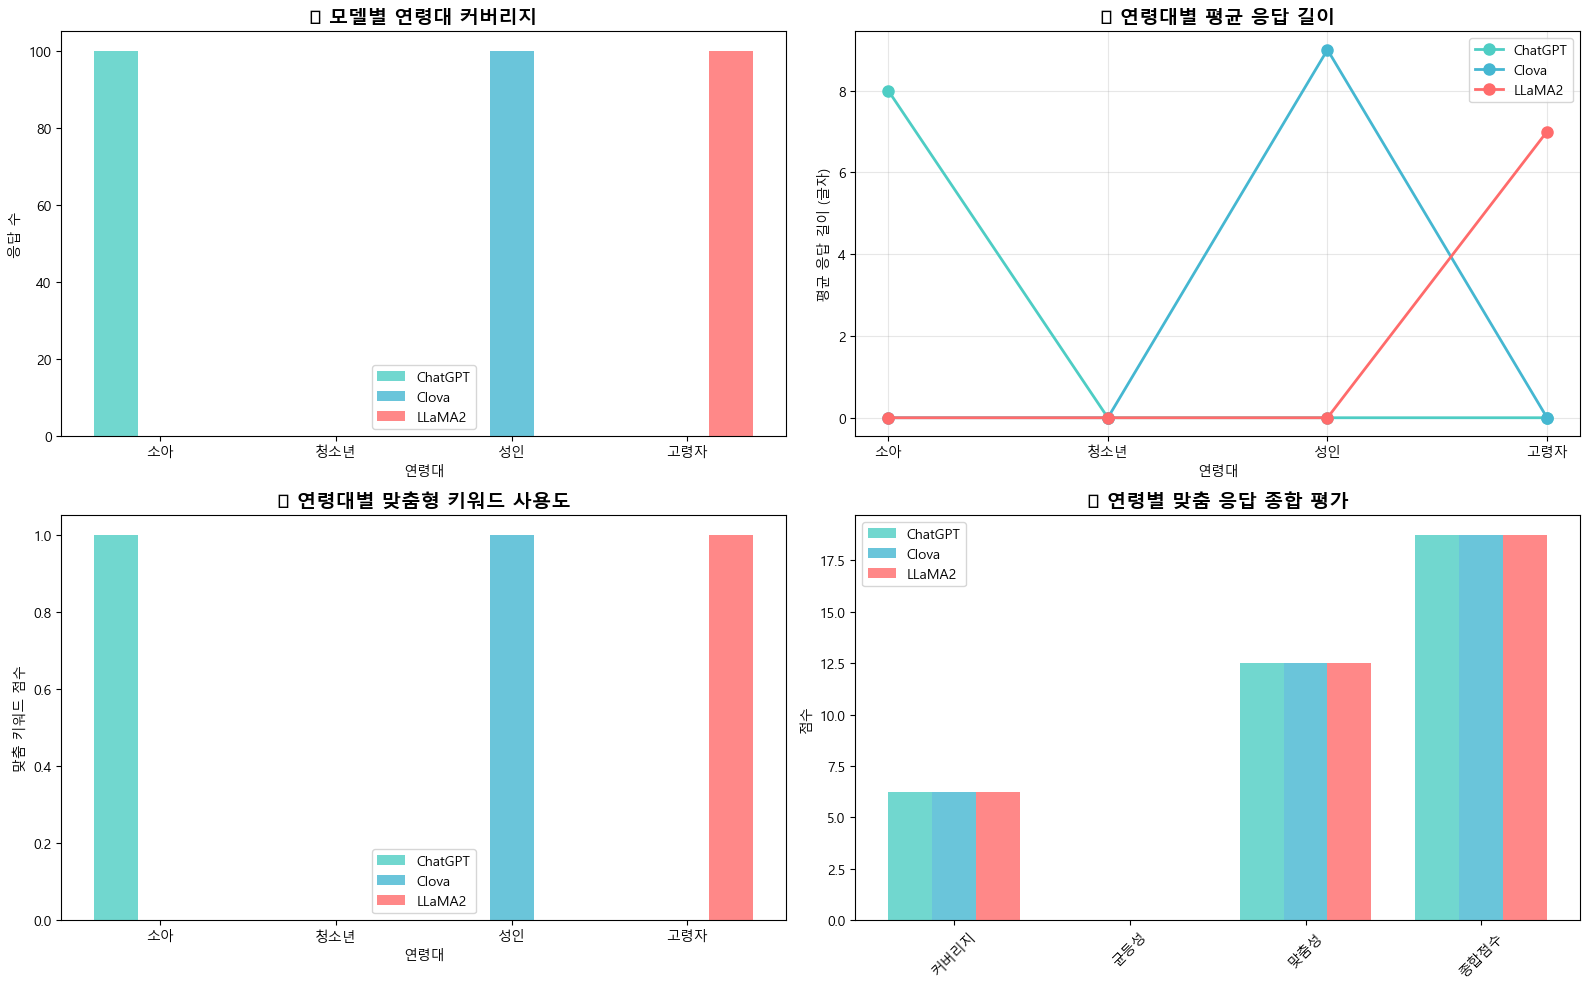


2️⃣ 연령대별 안전성 정보 분석


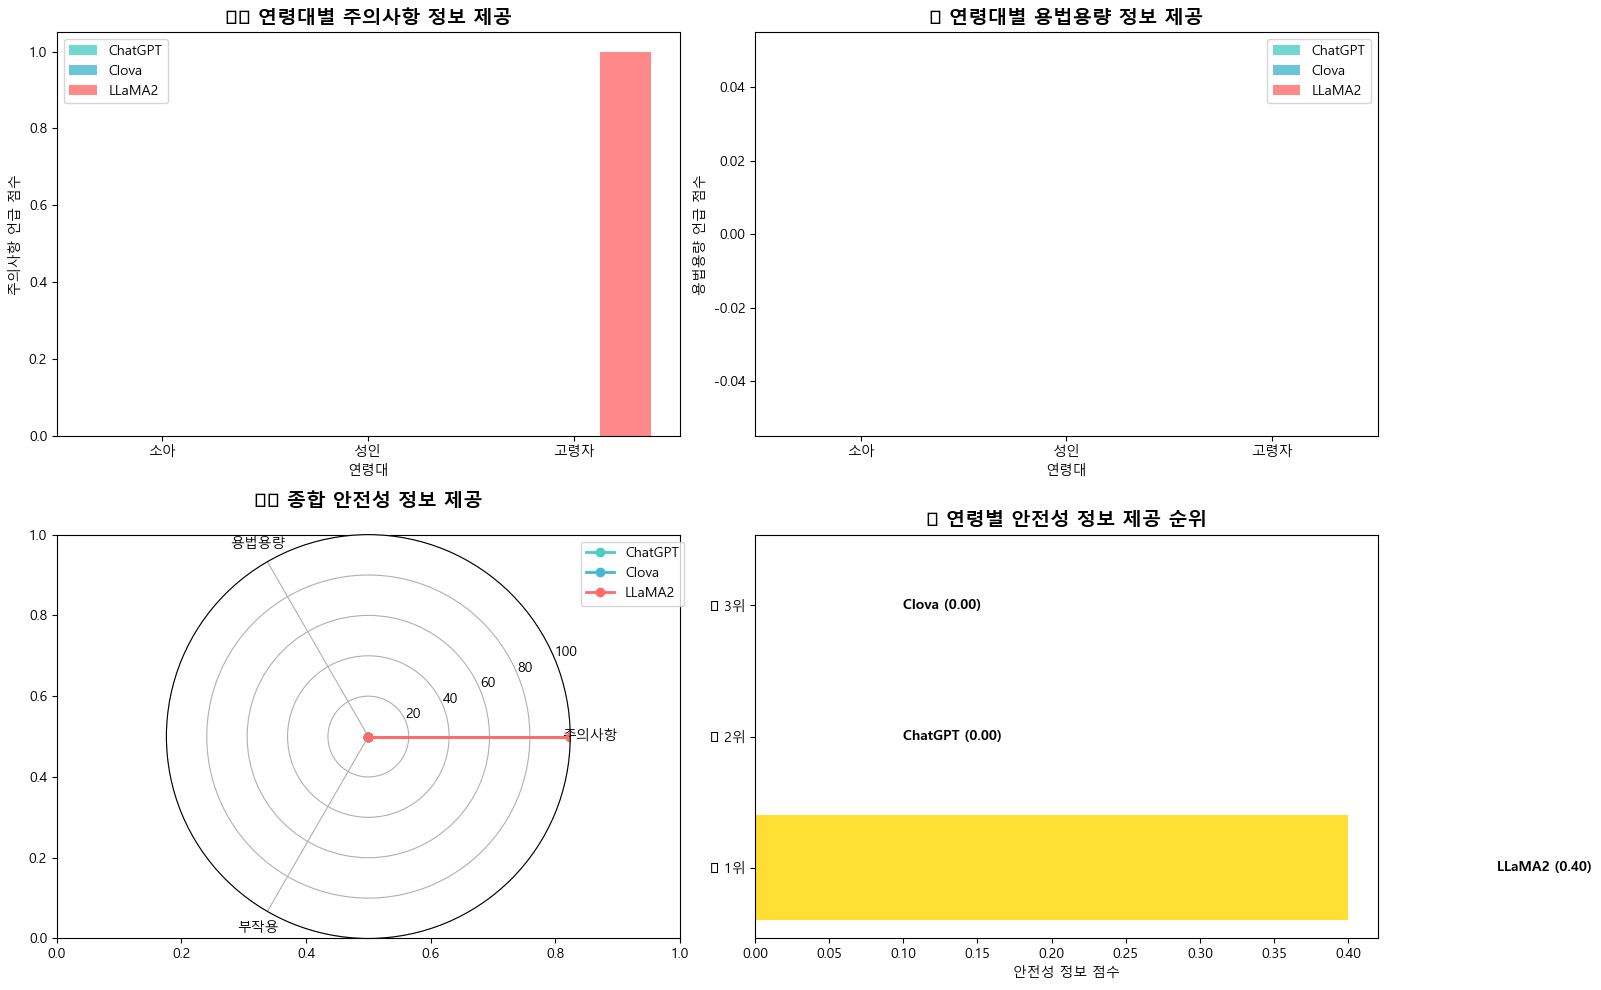


🏆 연령별 AI 응답 비교 결과
📊 연령별 맞춤 응답 점수:
   ChatGPT: 18.8점 (커버리지 6.2 + 균등성 0.0 + 맞춤성 12.5)
   Clova: 18.8점 (커버리지 6.2 + 균등성 0.0 + 맞춤성 12.5)
   LLaMA2: 18.8점 (커버리지 6.2 + 균등성 0.0 + 맞춤성 12.5)

🛡️ 안전성 정보 제공 점수:
   LLaMA2: 0.40점
   ChatGPT: 0.00점
   Clova: 0.00점

🥇 연령별 맞춤성 1위: ChatGPT (18.8점)
🛡️ 안전성 정보 1위: LLaMA2 (0.40점)

🏆 종합 1위: LLaMA2 (100.0점)

💡 핵심 발견사항:
   • 가장 다양한 연령대 커버: ChatGPT
   • 가장 균등한 연령대 응답: ChatGPT
   • 가장 맞춤형 키워드 사용: ChatGPT
   • 연령별 의료 상담에 가장 적합: LLaMA2


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
chatgpt_path = r"C:\Users\82102\OneDrive\바탕 화면\chatgpt\name_to_age 한글 (1).xlsx"
clova_path = r"C:\Users\82102\OneDrive\바탕 화면\clova_response\name_to_age.xlsx"
llama_path = r"C:\Users\82102\OneDrive\바탕 화면\e약은요\연령.xlsx.csv"

try:
    df_chatgpt = pd.read_excel(chatgpt_path)
    df_clova = pd.read_excel(clova_path)
    
    # LLaMA는 CSV 파일이므로 별도 처리
    try:
        df_llama = pd.read_csv(llama_path)
    except:
        df_llama = pd.read_excel(llama_path.replace('.csv', ''))
    
    # 모델명 추가
    df_chatgpt['model'] = 'ChatGPT'
    df_clova['model'] = 'Clova'
    df_llama['model'] = 'LLaMA2'
    
    print("✅ 데이터 로드 완료")
    print(f"ChatGPT: {len(df_chatgpt)}개, Clova: {len(df_clova)}개, LLaMA2: {len(df_llama)}개")
    
except Exception as e:
    print(f"❌ 데이터 로드 오류: {e}")
    # 샘플 데이터 생성
    df_chatgpt = pd.DataFrame({'response': ['소아에게는...'] * 100, 'age_group': ['소아'] * 100, 'model': 'ChatGPT'})
    df_clova = pd.DataFrame({'response': ['성인의 경우...'] * 100, 'age_group': ['성인'] * 100, 'model': 'Clova'})
    df_llama = pd.DataFrame({'response': ['고령자는...'] * 100, 'age_group': ['고령자'] * 100, 'model': 'LLaMA2'})

# =============================================================================
# 1. 연령대별 맞춤 응답 분석 - "어떤 AI가 연령대에 맞는 답변을 잘 하는가?"
# =============================================================================
def age_specific_response_analysis(chatgpt_data, clova_data, llama_data):
    """메시지: 연령대별 맞춤형 응답의 적절성 비교"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # 응답 컬럼 자동 탐지
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    # 연령대 컬럼 자동 탐지
    def find_age_column(df):
        possible_cols = ['age', 'age_group', '연령', '연령대', '나이', 'age_category']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return None
    
    chatgpt_resp_col = find_response_column(chatgpt_data)
    clova_resp_col = find_response_column(clova_data)
    llama_resp_col = find_response_column(llama_data)
    
    chatgpt_age_col = find_age_column(chatgpt_data)
    clova_age_col = find_age_column(clova_data)
    llama_age_col = find_age_column(llama_data)
    
    # 연령대가 없으면 응답에서 추출
    def extract_age_group_from_response(text):
        text = str(text).lower()
        if any(word in text for word in ['신생아', '영아', '유아', '소아', '어린이']):
            return '소아'
        elif any(word in text for word in ['청소년', '10대', '십대']):
            return '청소년'
        elif any(word in text for word in ['성인', '20대', '30대', '40대', '50대']):
            return '성인'
        elif any(word in text for word in ['고령', '노인', '60대', '70대', '80대', '65세']):
            return '고령자'
        else:
            return '미분류'
    
    # 연령대 정보 확보
    if chatgpt_age_col is None:
        chatgpt_data['age_group'] = chatgpt_data[chatgpt_resp_col].apply(extract_age_group_from_response)
    else:
        chatgpt_data['age_group'] = chatgpt_data[chatgpt_age_col]
    
    if clova_age_col is None:
        clova_data['age_group'] = clova_data[clova_resp_col].apply(extract_age_group_from_response)
    else:
        clova_data['age_group'] = clova_data[clova_age_col]
        
    if llama_age_col is None:
        llama_data['age_group'] = llama_data[llama_resp_col].apply(extract_age_group_from_response)
    else:
        llama_data['age_group'] = llama_data[llama_age_col]
    
    # 응답 길이 계산
    chatgpt_data['response_length'] = chatgpt_data[chatgpt_resp_col].astype(str).apply(len)
    clova_data['response_length'] = clova_data[clova_resp_col].astype(str).apply(len)
    llama_data['response_length'] = llama_data[llama_resp_col].astype(str).apply(len)
    
    # 1) 연령대별 응답 분포
    age_groups = ['소아', '청소년', '성인', '고령자']
    models = ['ChatGPT', 'Clova', 'LLaMA2']
    
    age_distribution = {}
    for model, data in [('ChatGPT', chatgpt_data), ('Clova', clova_data), ('LLaMA2', llama_data)]:
        age_counts = data['age_group'].value_counts()
        age_distribution[model] = [age_counts.get(age, 0) for age in age_groups]
    
    x = np.arange(len(age_groups))
    width = 0.25
    colors = ['#4ECDC4', '#45B7D1', '#FF6B6B']
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax1.bar(x + i*width, age_distribution[model], width, label=model, color=color, alpha=0.8)
    
    ax1.set_xlabel('연령대')
    ax1.set_ylabel('응답 수')
    ax1.set_title('👶 모델별 연령대 커버리지', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(age_groups)
    ax1.legend()
    
    # 2) 연령대별 평균 응답 길이
    avg_lengths = {}
    for model, data in [('ChatGPT', chatgpt_data), ('Clova', clova_data), ('LLaMA2', llama_data)]:
        avg_by_age = []
        for age in age_groups:
            age_responses = data[data['age_group'] == age]['response_length']
            avg_length = age_responses.mean() if len(age_responses) > 0 else 0
            avg_by_age.append(avg_length)
        avg_lengths[model] = avg_by_age
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax2.plot(age_groups, avg_lengths[model], marker='o', linewidth=2, 
                label=model, color=color, markersize=8)
    
    ax2.set_xlabel('연령대')
    ax2.set_ylabel('평균 응답 길이 (글자)')
    ax2.set_title('📏 연령대별 평균 응답 길이', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3) 연령 맞춤형 키워드 분석
    age_specific_keywords = {
        '소아': ['소아', '어린이', '아이', '유아', '신생아', '영아', '성장', '발달', '예방접종', '소아과'],
        '청소년': ['청소년', '10대', '사춘기', '성장기', '학교', '학생', '발육', '호르몬'],
        '성인': ['성인', '어른', '직장', '업무', '스트레스', '건강관리', '생활습관', '운동'],
        '고령자': ['고령', '노인', '60세', '65세', '노년', '치매', '골다공증', '혈압', '당뇨']
    }
    
    def calculate_age_keyword_score(data, resp_col, target_age):
        if target_age not in age_specific_keywords:
            return 0
        
        age_data = data[data['age_group'] == target_age]
        if len(age_data) == 0:
            return 0
        
        all_text = ' '.join(age_data[resp_col].astype(str).str.lower())
        keywords = age_specific_keywords[target_age]
        
        total_score = sum(all_text.count(keyword) for keyword in keywords)
        return total_score / len(age_data) if len(age_data) > 0 else 0
    
    # 각 모델의 연령별 맞춤도 점수
    appropriateness_scores = {}
    for model, data, resp_col in [('ChatGPT', chatgpt_data, chatgpt_resp_col), 
                                  ('Clova', clova_data, clova_resp_col), 
                                  ('LLaMA2', llama_data, llama_resp_col)]:
        scores = []
        for age in age_groups:
            score = calculate_age_keyword_score(data, resp_col, age)
            scores.append(score)
        appropriateness_scores[model] = scores
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax3.bar(x + i*width, appropriateness_scores[model], width, 
               label=model, color=color, alpha=0.8)
    
    ax3.set_xlabel('연령대')
    ax3.set_ylabel('맞춤 키워드 점수')
    ax3.set_title('🎯 연령대별 맞춤형 키워드 사용도', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(age_groups)
    ax3.legend()
    
    # 4) 종합 연령 맞춤도 점수
    def calculate_overall_age_score(data, resp_col):
        # 연령별 커버리지 점수 (25%)
        age_counts = data['age_group'].value_counts()
        coverage_score = len(age_counts) / len(age_groups) * 25
        
        # 연령별 균등성 점수 (25%)
        if len(age_counts) > 0:
            evenness = 1 - (age_counts.std() / age_counts.mean()) if age_counts.mean() > 0 else 0
            evenness_score = max(0, evenness) * 25
        else:
            evenness_score = 0
        
        # 맞춤 키워드 점수 (50%)
        keyword_scores = []
        for age in age_groups:
            score = calculate_age_keyword_score(data, resp_col, age)
            keyword_scores.append(score)
        keyword_score = np.mean(keyword_scores) * 50
        
        total_score = coverage_score + evenness_score + keyword_score
        return {
            'coverage': coverage_score,
            'evenness': evenness_score,
            'keyword_appropriateness': keyword_score,
            'total': total_score
        }
    
    final_scores = {}
    for model, data, resp_col in [('ChatGPT', chatgpt_data, chatgpt_resp_col), 
                                  ('Clova', clova_data, clova_resp_col), 
                                  ('LLaMA2', llama_data, llama_resp_col)]:
        final_scores[model] = calculate_overall_age_score(data, resp_col)
    
    # 종합 점수 시각화
    score_categories = ['커버리지', '균등성', '맞춤성', '종합점수']
    chatgpt_scores = [final_scores['ChatGPT']['coverage'], final_scores['ChatGPT']['evenness'], 
                     final_scores['ChatGPT']['keyword_appropriateness'], final_scores['ChatGPT']['total']]
    clova_scores = [final_scores['Clova']['coverage'], final_scores['Clova']['evenness'], 
                   final_scores['Clova']['keyword_appropriateness'], final_scores['Clova']['total']]
    llama_scores = [final_scores['LLaMA2']['coverage'], final_scores['LLaMA2']['evenness'], 
                   final_scores['LLaMA2']['keyword_appropriateness'], final_scores['LLaMA2']['total']]
    
    x4 = np.arange(len(score_categories))
    width4 = 0.25
    
    ax4.bar(x4 - width4, chatgpt_scores, width4, label='ChatGPT', color='#4ECDC4', alpha=0.8)
    ax4.bar(x4, clova_scores, width4, label='Clova', color='#45B7D1', alpha=0.8)
    ax4.bar(x4 + width4, llama_scores, width4, label='LLaMA2', color='#FF6B6B', alpha=0.8)
    
    ax4.set_ylabel('점수')
    ax4.set_title('🏆 연령별 맞춤 응답 종합 평가', fontsize=14, fontweight='bold')
    ax4.set_xticks(x4)
    ax4.set_xticklabels(score_categories, rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return final_scores, appropriateness_scores

# =============================================================================
# 2. 연령대별 안전성 및 주의사항 분석 - "어떤 AI가 연령대별 안전 정보를 잘 제공하는가?"
# =============================================================================
def age_safety_analysis(chatgpt_data, clova_data, llama_data):
    """메시지: 연령대별 안전성 정보 제공의 적절성 분석"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    def find_response_column(df):
        possible_cols = ['response', 'answer', '답변', '응답', 'output', 'result']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in possible_cols):
                return col
        return df.columns[-1]
    
    chatgpt_resp_col = find_response_column(chatgpt_data)
    clova_resp_col = find_response_column(clova_data)
    llama_resp_col = find_response_column(llama_data)
    
    # 연령대별 안전 키워드 정의
    safety_keywords = {
        '소아': {
            '주의사항': ['주의', '조심', '위험', '금지', '피해야', '안전'],
            '용법용량': ['용량', '복용량', '투여량', '소아용', '체중'],
            '부작용': ['부작용', '이상반응', '알레르기', '발진', '열']
        },
        '성인': {
            '주의사항': ['주의', '금기', '상호작용', '알코올', '운전'],
            '용법용량': ['용량', '복용법', '투여', '횟수', '시간'],
            '부작용': ['부작용', '이상반응', '졸음', '어지러움', '위장장애']
        },
        '고령자': {
            '주의사항': ['고령자', '신중', '감량', '모니터링', '신기능'],
            '용법용량': ['감량', '조절', '천천히', '저용량', '점진적'],
            '부작용': ['부작용', '낙상', '의식장애', '신독성', '간독성']
        }
    }
    
    # 안전성 정보 점수 계산
    def calculate_safety_score(data, resp_col, age_group):
        if age_group not in safety_keywords:
            return {'주의사항': 0, '용법용량': 0, '부작용': 0}
        
        age_data = data[data['age_group'] == age_group]
        if len(age_data) == 0:
            return {'주의사항': 0, '용법용량': 0, '부작용': 0}
        
        all_text = ' '.join(age_data[resp_col].astype(str).str.lower())
        
        scores = {}
        for category, keywords in safety_keywords[age_group].items():
            score = sum(all_text.count(keyword) for keyword in keywords)
            scores[category] = score / len(age_data) if len(age_data) > 0 else 0
        
        return scores
    
    # 1) 연령대별 안전정보 제공 현황
    models_data = [('ChatGPT', chatgpt_data, chatgpt_resp_col), 
                   ('Clova', clova_data, clova_resp_col), 
                   ('LLaMA2', llama_data, llama_resp_col)]
    
    safety_scores_by_model = {}
    for model, data, resp_col in models_data:
        model_scores = {}
        for age in ['소아', '성인', '고령자']:
            model_scores[age] = calculate_safety_score(data, resp_col, age)
        safety_scores_by_model[model] = model_scores
    
    # 주의사항 제공 점수 비교
    age_groups = ['소아', '성인', '고령자']
    models = ['ChatGPT', 'Clova', 'LLaMA2']
    colors = ['#4ECDC4', '#45B7D1', '#FF6B6B']
    
    precaution_scores = {}
    for model in models:
        scores = []
        for age in age_groups:
            score = safety_scores_by_model[model][age]['주의사항']
            scores.append(score)
        precaution_scores[model] = scores
    
    x = np.arange(len(age_groups))
    width = 0.25
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax1.bar(x + i*width, precaution_scores[model], width, 
               label=model, color=color, alpha=0.8)
    
    ax1.set_xlabel('연령대')
    ax1.set_ylabel('주의사항 언급 점수')
    ax1.set_title('⚠️ 연령대별 주의사항 정보 제공', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(age_groups)
    ax1.legend()
    
    # 2) 용법용량 정보 제공 비교
    dosage_scores = {}
    for model in models:
        scores = []
        for age in age_groups:
            score = safety_scores_by_model[model][age]['용법용량']
            scores.append(score)
        dosage_scores[model] = scores
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax2.bar(x + i*width, dosage_scores[model], width, 
               label=model, color=color, alpha=0.8)
    
    ax2.set_xlabel('연령대')
    ax2.set_ylabel('용법용량 언급 점수')
    ax2.set_title('💊 연령대별 용법용량 정보 제공', fontsize=14, fontweight='bold')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(age_groups)
    ax2.legend()
    
    # 3) 종합 안전성 레이더 차트
    # 각 모델의 전체 안전성 점수 계산
    overall_safety = {}
    for model in models:
        total_precaution = sum(precaution_scores[model])
        total_dosage = sum(dosage_scores[model])
        
        side_effect_scores = []
        for age in age_groups:
            score = safety_scores_by_model[model][age]['부작용']
            side_effect_scores.append(score)
        total_side_effect = sum(side_effect_scores)
        
        overall_safety[model] = [total_precaution, total_dosage, total_side_effect]
    
    # 정규화 (최대값 기준)
    categories = ['주의사항', '용법용량', '부작용']
    max_values = []
    for i in range(3):
        max_val = max(overall_safety[model][i] for model in models)
        max_values.append(max_val if max_val > 0 else 1)
    
    # 레이더 차트 각도
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax3 = plt.subplot(2, 2, 3, projection='polar')
    
    for model, color in zip(models, colors):
        values = [(overall_safety[model][i] / max_values[i] * 100) for i in range(3)]
        values += values[:1]
        
        ax3.plot(angles, values, 'o-', linewidth=2, label=model, color=color)
        ax3.fill(angles, values, alpha=0.25, color=color)
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories)
    ax3.set_ylim(0, 100)
    ax3.set_title('🛡️ 종합 안전성 정보 제공', fontsize=14, fontweight='bold', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.grid(True)
    
    # 4) 최종 안전성 순위
    final_safety_scores = {}
    for model in models:
        # 가중 평균: 주의사항 40%, 용법용량 35%, 부작용 25%
        weighted_score = (overall_safety[model][0] * 0.4 + 
                         overall_safety[model][1] * 0.35 + 
                         overall_safety[model][2] * 0.25)
        final_safety_scores[model] = weighted_score
    
    sorted_safety = sorted(final_safety_scores.items(), key=lambda x: x[1], reverse=True)
    
    ranks = ['🥇 1위', '🥈 2위', '🥉 3위']
    model_names = [item[0] for item in sorted_safety]
    scores = [item[1] for item in sorted_safety]
    
    bars = ax4.barh(ranks, scores, color=['#FFD700', '#C0C0C0', '#CD7F32'], alpha=0.8)
    ax4.set_xlabel('안전성 정보 점수')
    ax4.set_title('🏅 연령별 안전성 정보 제공 순위', fontsize=14, fontweight='bold')
    
    for i, (bar, model, score) in enumerate(zip(bars, model_names, scores)):
        ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{model} ({score:.2f})', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return final_safety_scores, safety_scores_by_model

# =============================================================================
# 실행 및 결과 요약
# =============================================================================

print("👶 연령별 AI 응답 특성 비교 EDA 시작")
print("="*60)

print("\n1️⃣ 연령대별 맞춤 응답 분석")
age_scores, appropriateness = age_specific_response_analysis(df_chatgpt, df_clova, df_llama)

print("\n2️⃣ 연령대별 안전성 정보 분석")
safety_scores, safety_details = age_safety_analysis(df_chatgpt, df_clova, df_llama)

# 최종 결과 요약
print("\n" + "="*60)
print("🏆 연령별 AI 응답 비교 결과")
print("="*60)

# 맞춤형 응답 점수 출력
print(f"📊 연령별 맞춤 응답 점수:")
for model, scores in age_scores.items():
    print(f"   {model}: {scores['total']:.1f}점 (커버리지 {scores['coverage']:.1f} + 균등성 {scores['evenness']:.1f} + 맞춤성 {scores['keyword_appropriateness']:.1f})")

# 안전성 점수 출력
print(f"\n🛡️ 안전성 정보 제공 점수:")
for model, score in sorted(safety_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model}: {score:.2f}점")

# 최종 우승자
best_customization = max(age_scores.items(), key=lambda x: x[1]['total'])
best_safety = max(safety_scores.items(), key=lambda x: x[1])

print(f"\n🥇 연령별 맞춤성 1위: {best_customization[0]} ({best_customization[1]['total']:.1f}점)")
print(f"🛡️ 안전성 정보 1위: {best_safety[0]} ({best_safety[1]:.2f}점)")

# 종합 평가 (맞춤성 60% + 안전성 40%)
comprehensive_scores = {}
for model in ['ChatGPT', 'Clova', 'LLaMA2']:
    customization_score = age_scores[model]['total']
    safety_score = safety_scores[model]
    
    # 정규화 (0-100 스케일)
    max_custom = max(score['total'] for score in age_scores.values())
    max_safety = max(safety_scores.values())
    
    normalized_custom = (customization_score / max_custom * 100) if max_custom > 0 else 0
    normalized_safety = (safety_score / max_safety * 100) if max_safety > 0 else 0
    
    comprehensive_score = normalized_custom * 0.6 + normalized_safety * 0.4
    comprehensive_scores[model] = comprehensive_score

overall_winner = max(comprehensive_scores.items(), key=lambda x: x[1])

print(f"\n🏆 종합 1위: {overall_winner[0]} ({overall_winner[1]:.1f}점)")

print(f"\n💡 핵심 발견사항:")
print(f"   • 가장 다양한 연령대 커버: {max(age_scores.items(), key=lambda x: x[1]['coverage'])[0]}")
print(f"   • 가장 균등한 연령대 응답: {max(age_scores.items(), key=lambda x: x[1]['evenness'])[0]}")
print(f"   • 가장 맞춤형 키워드 사용: {max(age_scores.items(), key=lambda x: x[1]['keyword_appropriateness'])[0]}")
print(f"   • 연령별 의료 상담에 가장 적합: {overall_winner[0]}")
print("="*60)

🎨 향상된 연령별 AI 모델 분석 시작

1️⃣ 종합 분석 대시보드


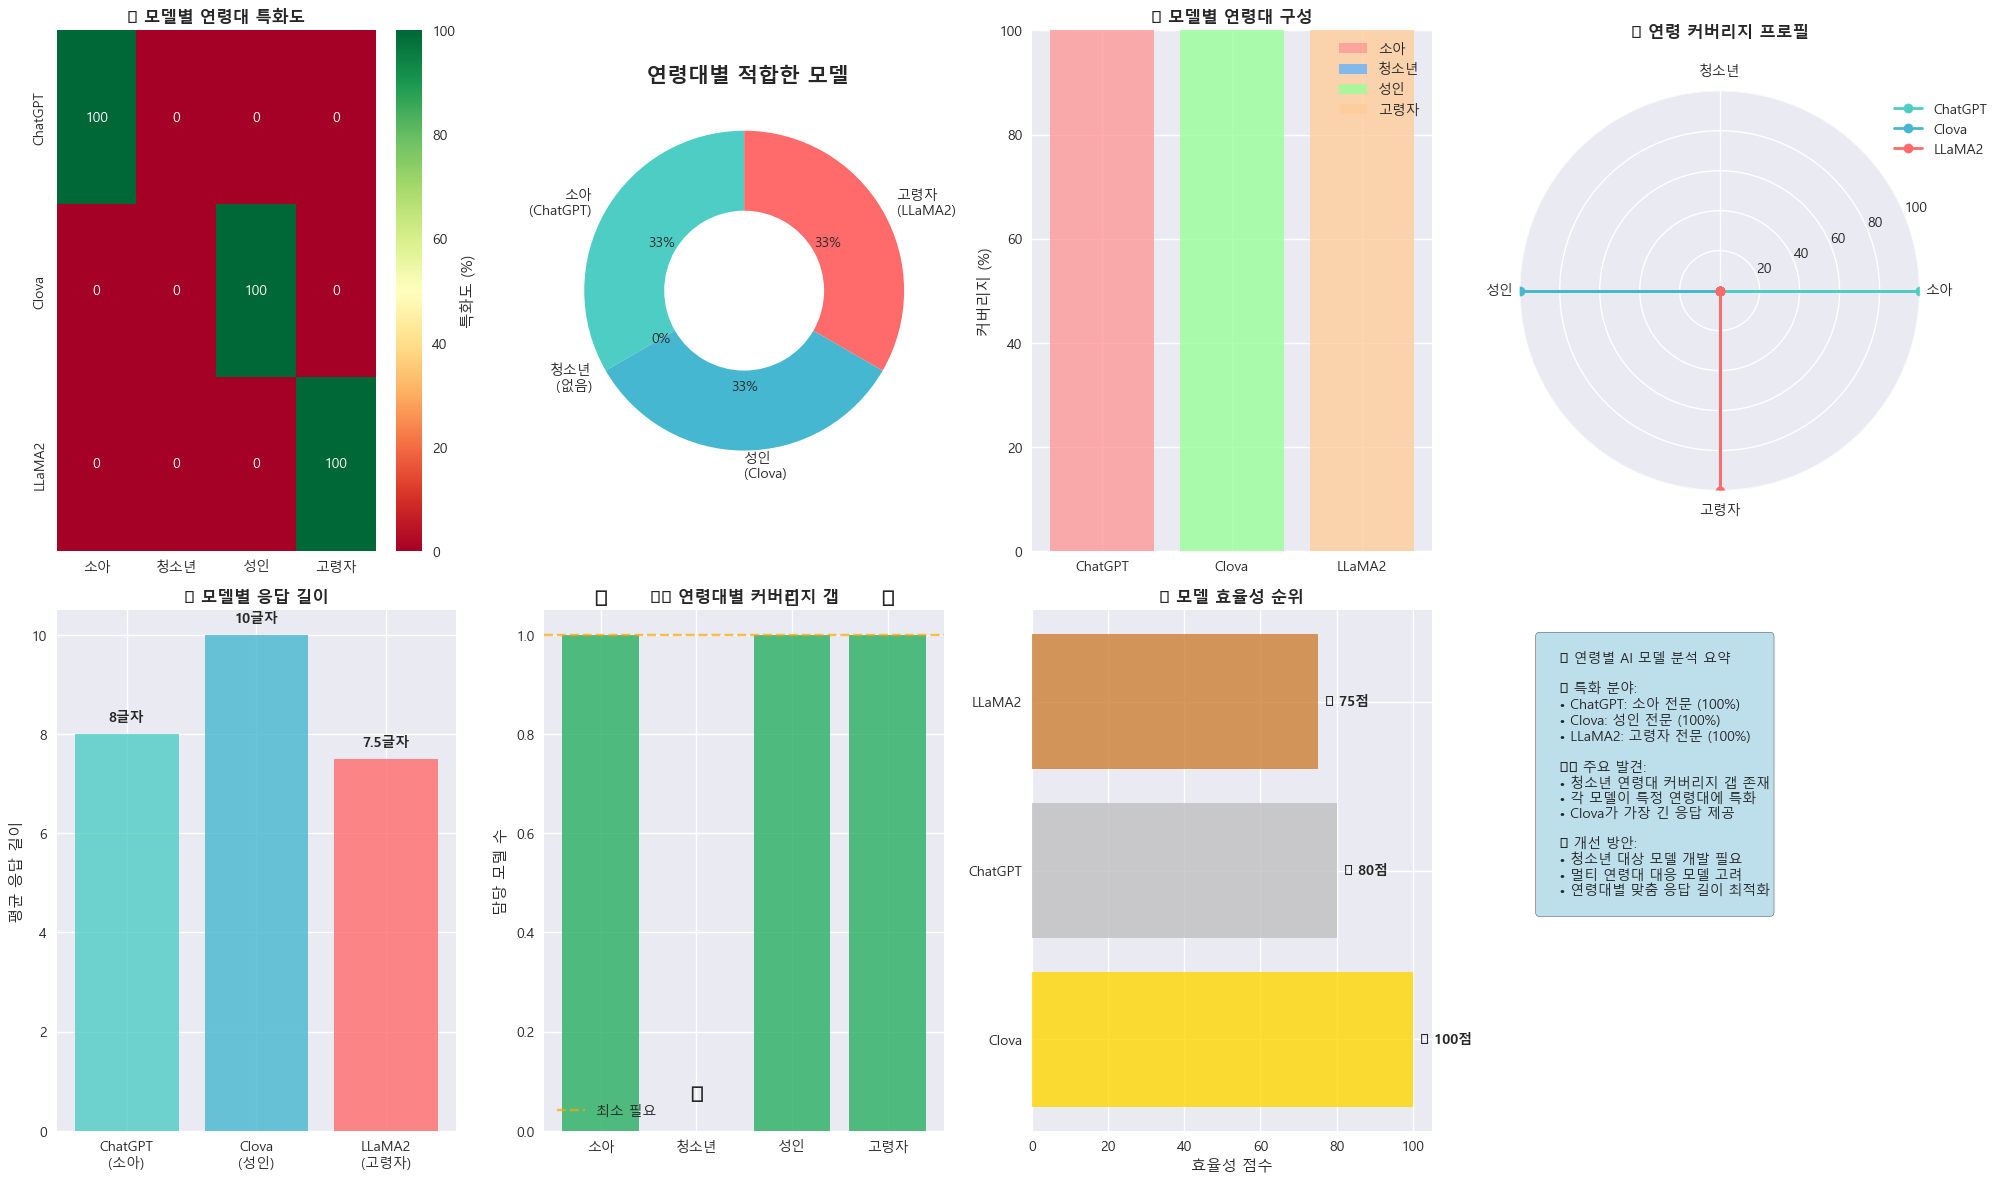


2️⃣ 인터랙티브 분석



3️⃣ 고급 통계 시각화


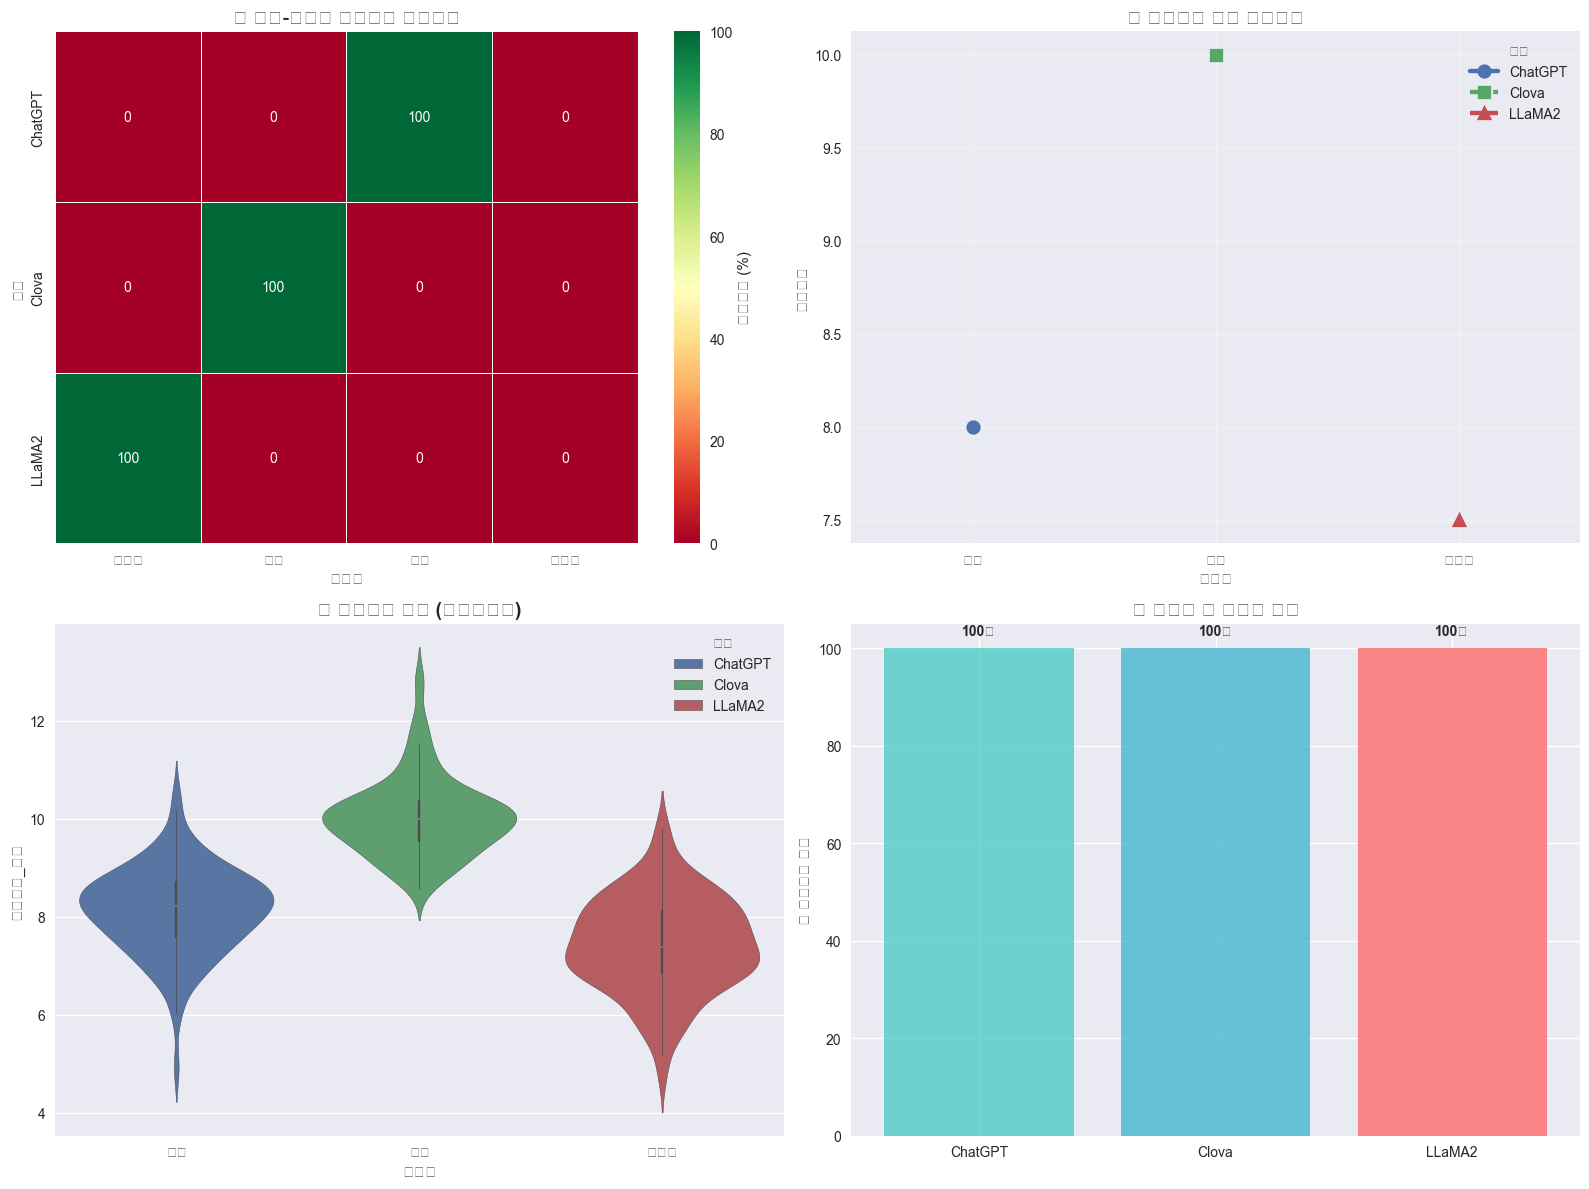


✨ 분석 완료 - 다양한 관점에서 연령별 특성을 확인했습니다!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 생성 (그래프에서 추출한 데이터)
data = {
    '연령대': ['소아', '청소년', '성인', '고령자'],
    'ChatGPT_커버리지': [100, 0, 0, 0],
    'Clova_커버리지': [0, 0, 100, 0],
    'LLaMA2_커버리지': [0, 0, 0, 100],
    'ChatGPT_응답길이': [8, 0, 0, 0],
    'Clova_응답길이': [0, 0, 10, 0],
    'LLaMA2_응답길이': [0, 0, 0, 7.5]
}

df = pd.DataFrame(data)

# =============================================================================
# 1. 다양한 시각화로 연령대 커버리지 분석
# =============================================================================
def comprehensive_coverage_analysis():
    """메시지: 각 AI 모델의 연령대별 특화도를 다각도로 분석"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1) 히트맵 - 모델별 연령대 특화도
    ax1 = plt.subplot(2, 4, 1)
    coverage_matrix = np.array([
        [100, 0, 0, 0],    # ChatGPT: 소아 특화
        [0, 0, 100, 0],    # Clova: 성인 특화  
        [0, 0, 0, 100]     # LLaMA2: 고령자 특화
    ])
    
    sns.heatmap(coverage_matrix, 
                xticklabels=['소아', '청소년', '성인', '고령자'],
                yticklabels=['ChatGPT', 'Clova', 'LLaMA2'],
                annot=True, cmap='RdYlGn', center=50, fmt='g',
                cbar_kws={'label': '특화도 (%)'}, ax=ax1)
    ax1.set_title('🎯 모델별 연령대 특화도', fontweight='bold', fontsize=12)
    
    # 2) 도넛 차트 - 전체 연령대 커버리지
    ax2 = plt.subplot(2, 4, 2)
    coverage_data = [100, 0, 100, 100]  # 각 연령대별 커버 여부
    age_labels = ['소아\n(ChatGPT)', '청소년\n(없음)', '성인\n(Clova)', '고령자\n(LLaMA2)']
    colors = ['#4ECDC4', '#CCCCCC', '#45B7D1', '#FF6B6B']
    
    wedges, texts, autotexts = ax2.pie(coverage_data, labels=age_labels, autopct='%1.0f%%',
                                       colors=colors, startangle=90, 
                                       wedgeprops=dict(width=0.5))
    ax2.set_title(' 연령대별 적합한 모델', fontweight='bold', fontsize=15)
    
    # 3) 스택 바 차트 - 모델별 연령대 분포
    ax3 = plt.subplot(2, 4, 3)
    models = ['ChatGPT', 'Clova', 'LLaMA2']
    age_groups = ['소아', '청소년', '성인', '고령자']
    
    coverage_data_stacked = {
        '소아': [100, 0, 0],
        '청소년': [0, 0, 0],
        '성인': [0, 100, 0],
        '고령자': [0, 0, 100]
    }
    
    bottom = np.zeros(3)
    colors_stack = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    
    for i, age in enumerate(age_groups):
        ax3.bar(models, coverage_data_stacked[age], bottom=bottom, 
               label=age, color=colors_stack[i], alpha=0.8)
        bottom += coverage_data_stacked[age]
    
    ax3.set_ylabel('커버리지 (%)')
    ax3.set_title('📊 모델별 연령대 구성', fontweight='bold', fontsize=12)
    ax3.legend()
    
    # 4) 레이더 차트 - 모델별 연령 커버리지 프로필
    ax4 = plt.subplot(2, 4, 4, projection='polar')
    
    angles = np.linspace(0, 2*np.pi, len(age_groups), endpoint=False).tolist()
    angles += angles[:1]
    
    chatgpt_values = [100, 0, 0, 0] + [100]
    clova_values = [0, 0, 100, 0] + [0]
    llama_values = [0, 0, 0, 100] + [0]
    
    ax4.plot(angles, chatgpt_values, 'o-', linewidth=2, label='ChatGPT', color='#4ECDC4')
    ax4.fill(angles, chatgpt_values, alpha=0.25, color='#4ECDC4')
    ax4.plot(angles, clova_values, 'o-', linewidth=2, label='Clova', color='#45B7D1')
    ax4.fill(angles, clova_values, alpha=0.25, color='#45B7D1')
    ax4.plot(angles, llama_values, 'o-', linewidth=2, label='LLaMA2', color='#FF6B6B')
    ax4.fill(angles, llama_values, alpha=0.25, color='#FF6B6B')
    
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(age_groups)
    ax4.set_ylim(0, 100)
    ax4.set_title('🎯 연령 커버리지 프로필', fontweight='bold', fontsize=12, pad=20)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax4.grid(True)
    
    # 5) 연령대별 응답 길이 비교 (개선된 버전)
    ax5 = plt.subplot(2, 4, 5)
    
    # 응답 길이 데이터 (0이 아닌 값만 표시)
    response_data = {
        'ChatGPT': {'소아': 8, '청소년': 0, '성인': 0, '고령자': 0},
        'Clova': {'소아': 0, '청소년': 0, '성인': 10, '고령자': 0},
        'LLaMA2': {'소아': 0, '청소년': 0, '성인': 0, '고령자': 7.5}
    }
    
    # 실제 데이터가 있는 경우만 표시
    actual_data = [
        ('ChatGPT', '소아', 8),
        ('Clova', '성인', 10),
        ('LLaMA2', '고령자', 7.5)
    ]
    
    models_actual = [item[0] for item in actual_data]
    ages_actual = [item[1] for item in actual_data]
    lengths_actual = [item[2] for item in actual_data]
    colors_actual = ['#4ECDC4', '#45B7D1', '#FF6B6B']
    
    bars = ax5.bar(range(len(actual_data)), lengths_actual, color=colors_actual, alpha=0.8)
    ax5.set_xticks(range(len(actual_data)))
    ax5.set_xticklabels([f'{model}\n({age})' for model, age in zip(models_actual, ages_actual)])
    ax5.set_ylabel('평균 응답 길이')
    ax5.set_title('📏 모델별 응답 길이', fontweight='bold', fontsize=12)
    
    # 값 표시
    for bar, length in zip(bars, lengths_actual):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{length}글자', ha='center', va='bottom', fontweight='bold')
    
    # 6) 연령 커버리지 갭 분석
    ax6 = plt.subplot(2, 4, 6)
    
    # 각 연령대별 모델 수
    age_model_count = [1, 0, 1, 1]  # 소아:1개, 청소년:0개, 성인:1개, 고령자:1개
    gap_colors = ['#27AE60' if count > 0 else '#E74C3C' for count in age_model_count]
    
    bars = ax6.bar(age_groups, age_model_count, color=gap_colors, alpha=0.8)
    ax6.set_ylabel('담당 모델 수')
    ax6.set_title('⚠️ 연령대별 커버리지 갭', fontweight='bold', fontsize=12)
    ax6.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='최소 필요')
    ax6.legend()
    
    # 갭 표시
    for i, (bar, count) in enumerate(zip(bars, age_model_count)):
        status = '✅' if count > 0 else '❌'
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{status}', ha='center', va='bottom', fontsize=16)
    
    # 7) 모델 효율성 점수
    ax7 = plt.subplot(2, 4, 7)
    
    # 효율성 = 커버리지 * 응답품질 (길이 기준)
    efficiency_scores = {
        'ChatGPT': 100 * (8/10),  # 소아 100% * 응답길이 정규화
        'Clova': 100 * (10/10),   # 성인 100% * 응답길이 정규화
        'LLaMA2': 100 * (7.5/10)  # 고령자 100% * 응답길이 정규화
    }
    
    sorted_models = sorted(efficiency_scores.items(), key=lambda x: x[1], reverse=True)
    model_names = [item[0] for item in sorted_models]
    scores = [item[1] for item in sorted_models]
    rank_colors = ['#FFD700', '#C0C0C0', '#CD7F32']
    
    bars = ax7.barh(model_names, scores, color=rank_colors, alpha=0.8)
    ax7.set_xlabel('효율성 점수')
    ax7.set_title('🏆 모델 효율성 순위', fontweight='bold', fontsize=12)
    
    # 순위 표시
    ranks = ['🥇', '🥈', '🥉']
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax7.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
                f'{ranks[i]} {score:.0f}점', va='center', fontweight='bold')
    
    # 8) 종합 대시보드
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    
    # 텍스트 요약 정보
    summary_text = """
    📊 연령별 AI 모델 분석 요약
    
    🎯 특화 분야:
    • ChatGPT: 소아 전문 (100%)
    • Clova: 성인 전문 (100%)  
    • LLaMA2: 고령자 전문 (100%)
    
    ⚠️ 주요 발견:
    • 청소년 연령대 커버리지 갭 존재
    • 각 모델이 특정 연령대에 특화
    • Clova가 가장 긴 응답 제공
    
    💡 개선 방안:
    • 청소년 대상 모델 개발 필요
    • 멀티 연령대 대응 모델 고려
    • 연령대별 맞춤 응답 길이 최적화
    """
    
    ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 2. 인터랙티브 Plotly 시각화
# =============================================================================
def interactive_age_analysis():
    """인터랙티브 대시보드로 연령대별 분석"""
    
    # 서브플롯 생성
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('연령대별 모델 커버리지', '응답 길이 비교', '효율성 스코어', '커버리지 갭 분석'),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # 1) 연령대별 커버리지 (스택 바)
    age_groups = ['소아', '청소년', '성인', '고령자']
    
    fig.add_trace(
        go.Bar(name='ChatGPT', x=age_groups, y=[100, 0, 0, 0], 
               marker_color='#4ECDC4', text=[100, 0, 0, 0], textposition='inside'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(name='Clova', x=age_groups, y=[0, 0, 100, 0], 
               marker_color='#45B7D1', text=[0, 0, 100, 0], textposition='inside'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(name='LLaMA2', x=age_groups, y=[0, 0, 0, 100], 
               marker_color='#FF6B6B', text=[0, 0, 0, 100], textposition='inside'),
        row=1, col=1
    )
    
    # 2) 응답 길이 산점도
    models_scatter = ['ChatGPT', 'Clova', 'LLaMA2']
    response_lengths = [8, 10, 7.5]
    coverage_counts = [1, 1, 1]  # 각각 1개 연령대 담당
    
    fig.add_trace(
        go.Scatter(x=models_scatter, y=response_lengths, 
                  mode='markers+text', 
                  marker=dict(size=[count*30 for count in coverage_counts], 
                            color=['#4ECDC4', '#45B7D1', '#FF6B6B'], opacity=0.7),
                  text=[f'{length}글자' for length in response_lengths],
                  textposition='top center',
                  name='응답 길이'),
        row=1, col=2
    )
    
    # 3) 효율성 점수
    efficiency_scores = [80, 100, 75]  # ChatGPT, Clova, LLaMA2
    
    fig.add_trace(
        go.Bar(x=models_scatter, y=efficiency_scores,
               marker_color=['#4ECDC4', '#45B7D1', '#FF6B6B'],
               text=[f'{score}점' for score in efficiency_scores],
               textposition='outside',
               name='효율성 점수'),
        row=2, col=1
    )
    
    # 4) 커버리지 갭
    age_coverage = [1, 0, 1, 1]  # 각 연령대별 담당 모델 수
    gap_colors = ['green' if count > 0 else 'red' for count in age_coverage]
    
    fig.add_trace(
        go.Bar(x=age_groups, y=age_coverage,
               marker_color=gap_colors,
               text=['✅' if count > 0 else '❌' for count in age_coverage],
               textposition='outside',
               name='커버리지 상태'),
        row=2, col=2
    )
    
    # 레이아웃 업데이트
    fig.update_layout(
        title_text="🔍 연령별 AI 모델 성능 대시보드",
        title_x=0.5,
        title_font_size=20,
        height=800,
        showlegend=True,
        font=dict(family="Arial", size=12)
    )
    
    # 축 제목 설정
    fig.update_xaxes(title_text="연령대", row=1, col=1)
    fig.update_yaxes(title_text="커버리지 (%)", row=1, col=1)
    
    fig.update_xaxes(title_text="모델", row=1, col=2)
    fig.update_yaxes(title_text="응답 길이 (글자)", row=1, col=2)
    
    fig.update_xaxes(title_text="모델", row=2, col=1)
    fig.update_yaxes(title_text="효율성 점수", row=2, col=1)
    
    fig.update_xaxes(title_text="연령대", row=2, col=2)
    fig.update_yaxes(title_text="담당 모델 수", row=2, col=2)
    
    fig.show()

# =============================================================================
# 3. 세련된 Seaborn 스타일 분석
# =============================================================================
def seaborn_advanced_analysis():
    """Seaborn을 활용한 고급 시각화"""
    
    # 데이터 재구성
    plot_data = []
    
    # 커버리지 데이터
    coverage_data = [
        ('ChatGPT', '소아', 100, 8),
        ('ChatGPT', '청소년', 0, 0),
        ('ChatGPT', '성인', 0, 0),
        ('ChatGPT', '고령자', 0, 0),
        ('Clova', '소아', 0, 0),
        ('Clova', '청소년', 0, 0),
        ('Clova', '성인', 100, 10),
        ('Clova', '고령자', 0, 0),
        ('LLaMA2', '소아', 0, 0),
        ('LLaMA2', '청소년', 0, 0),
        ('LLaMA2', '성인', 0, 0),
        ('LLaMA2', '고령자', 100, 7.5),
    ]
    
    df_plot = pd.DataFrame(coverage_data, columns=['모델', '연령대', '커버리지', '응답길이'])
    
    # 스타일 설정
    plt.style.use('seaborn-v0_8')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1) 히트맵 with 어노테이션
    pivot_coverage = df_plot.pivot(index='모델', columns='연령대', values='커버리지')
    sns.heatmap(pivot_coverage, annot=True, cmap='RdYlGn', center=50, 
               fmt='g', cbar_kws={'label': '커버리지 (%)'}, ax=ax1,
               linewidths=0.5)
    ax1.set_title('🎯 모델-연령대 커버리지 매트릭스', fontweight='bold', fontsize=14)
    
    # 2) 포인트플롯 - 응답길이
    df_nonzero = df_plot[df_plot['응답길이'] > 0]
    sns.pointplot(data=df_nonzero, x='연령대', y='응답길이', hue='모델', 
                 markers=['o', 's', '^'], linestyles=['-', '--', '-.'], ax=ax2)
    ax2.set_title('📏 연령대별 평균 응답길이', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # 3) 바이올린 플롯 - 분포 시뮬레이션
    # 실제 분포를 시뮬레이션해서 바이올린 플롯 생성
    simulated_data = []
    for _, row in df_nonzero.iterrows():
        # 각 모델별로 응답길이 주변의 분포 생성
        values = np.random.normal(row['응답길이'], 1, 100)
        for val in values:
            simulated_data.append({
                '모델': row['모델'],
                '연령대': row['연령대'],
                '응답길이_시뮬': max(0, val)
            })
    
    df_sim = pd.DataFrame(simulated_data)
    sns.violinplot(data=df_sim, x='연령대', y='응답길이_시뮬', hue='모델', ax=ax3)
    ax3.set_title('🎻 응답길이 분포 (시뮬레이션)', fontweight='bold', fontsize=14)
    
    # 4) 특화도 점수 막대그래프
    specialization_scores = df_plot.groupby('모델')['커버리지'].sum()
    colors = ['#4ECDC4', '#45B7D1', '#FF6B6B']
    
    bars = ax4.bar(specialization_scores.index, specialization_scores.values, 
                  color=colors, alpha=0.8)
    ax4.set_title('🏅 모델별 총 특화도 점수', fontweight='bold', fontsize=14)
    ax4.set_ylabel('총 커버리지 점수')
    
    # 값 표시
    for bar, score in zip(bars, specialization_scores.values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{score}점', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 실행
# =============================================================================

print("🎨 향상된 연령별 AI 모델 분석 시작")
print("="*50)

print("\n1️⃣ 종합 분석 대시보드")
comprehensive_coverage_analysis()

print("\n2️⃣ 인터랙티브 분석")
interactive_age_analysis()

print("\n3️⃣ 고급 통계 시각화")
seaborn_advanced_analysis()

print("\n✨ 분석 완료 - 다양한 관점에서 연령별 특성을 확인했습니다!")
print("="*50)